In [ ]:
!pip install --upgrade scikit-learn xgboost lightgbm

In [ ]:
# Importar bibliotecas necessárias
import os
import io
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Google Colab utilities
from google.colab import files

# Estatísticas e testes estatísticos
from scipy.stats import (
    kendalltau, pearsonr, spearmanr, shapiro, normaltest, levene, f_oneway,
    kruskal, pointbiserialr, chi2_contingency, kurtosis, skew, zscore
)
from scipy.spatial.distance import correlation

# Pré-processamento e manipulação de dados
from sklearn.preprocessing import (
    LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder
)
from sklearn.experimental import enable_iterative_imputer
from pandas.plotting import parallel_coordinates

# Seleção de características
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

# Modelos de machine learning
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold
)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Redução de dimensionalidade
from sklearn.decomposition import PCA

# Undersampling
from imblearn.under_sampling import TomekLinks, RandomUnderSampler

# Clusterização
from sklearn.cluster import KMeans

# Métricas de avaliação
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report,
    mean_absolute_error, r2_score, roc_auc_score, roc_curve, mutual_info_score
)

# General overview

### Importar e inspecionar os dados

#### Importar os dados

In [ ]:
file_name = "bank_data.csv"

if os.path.exists(file_name):
  df = pd.read_csv(file_name, sep=";")
else:
  uploaded = files.upload()
  df = pd.read_csv(io.BytesIO(uploaded[file_name]), sep=";")

#### Inspecionar os dados

In [ ]:
print(f"Número de linhas: {df.shape[0]}")
print(f"Número de colunas: {df.shape[1]}")


print("\n\n\n")
print("Informação sobre as colunas: ")
df.info()

Number of rows: 41188
Number of columns: 21




Columns info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.id

Neste dataset existe um total 41188 linhas e 21 colunas/features, sendo as colunas distribuidas da seguinte forma:

Numéricas:
age, duration, campaign, pdays, previous, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed

Categóricas:
job, marital, education, default, housing, loan, contact, month, day_of_week, poutcome, y

In [ ]:
df.nunique()

,0
age,78
job,12
marital,4
education,8
default,3
housing,3
loan,3
contact,2
month,10
day_of_week,5


Analisando o número de valores únicos por coluna conseguimos concluir que não existe nehuma coluna com valor constante (i.e. com variância 0) e como tal, não podemos para já remover nenhuma coluna

### Tratar os dados em falta e duplicados

#### Analisar duplicados

In [ ]:
df.duplicated().sum()

12

In [ ]:
df = df.drop_duplicates()

print(f"Número de linhas: {df.shape[0]}")

New number of rows: 41176


#### Analisar a percentagem e distribuição de dados em falta

Analisando o enunciado do trabalho é nos dito que os dados em falta ('Missing values') são identificados de forma geral neste dataset com o valor 'unknown'. Assim, por forma a facilitar a análise iremos transformá-los em Nan ('not a number') uma vez que as ferramentas de pandas estão preparadas para lidar melhor com este tipo de dado.

Para além destes casos é relevante notar ainda a informação extra dada durante as aulas:
- pdays: esta variável numérica tem alguns valores em falta, podendo-se assim assumir que o valor 999 representa de facto um missing value e pode ser substituido por Nan
- poutcome: em concordância com pdays esta variável representa esta variável categórica tem alguns valores em falta, podendo-se assim assumir que o valor 'nonexistent' representa de facto um missing value e pode ser substituido por Nan.

Tendo também por base esta última informação, pode-se também inferir o seguinte:
- previous: quando previous toma o valor 0 é possível observar que o valor de pdays é sempre 999 e o valor de poutcome é nonexistent. Assim podemos também assumir que o valor 0 na variável previous corresponde de facto a missing values

Após essa transformação poderemos então contar o número de entradas nulas para cada variável bem como a percentagem, isto é, a representatitivade de desconhecimento para cada feature

In [ ]:
# Fazer uma copia do dataframe e alterar os valores considerados "missing values" com Nan (na cópia) para evitar alterar os dados reais
df_copy = df.copy()
df_copy.replace('unknown', np.nan, inplace=True)
df_copy['pdays'] = df['pdays'].replace(999, np.nan)
df_copy['poutcome'] = df['poutcome'].replace('nonexistent', np.nan)
df_copy['previous'] = df['previous'].replace(0, np.nan)

#Validar o número de nulos por coluna
null_counts = df_copy.isnull().sum()
null_percentage = (null_counts / len(df)) * 100
null_summary = pd.DataFrame({
    'Null Count': null_counts,
    'Null Percentage': null_percentage
})

print(null_summary)

                Null Count  Null Percentage
age                      0         0.000000
job                    330         0.801438
marital                 80         0.194288
education             1730         4.201477
default               8596        20.876239
housing                990         2.404313
loan                   990         2.404313
contact                  0         0.000000
month                    0         0.000000
day_of_week              0         0.000000
duration                 0         0.000000
campaign                 0         0.000000
pdays                39661        96.320672
previous             35551        86.339130
poutcome             35551        86.339130
emp.var.rate             0         0.000000
cons.price.idx           0         0.000000
cons.conf.idx            0         0.000000
euribor3m                0         0.000000
nr.employed              0         0.000000
y                        0         0.000000


### Explorar caracteristicas dos dados

#### Analise Univariada

###### Numeric variables

In [ ]:
stats = df.describe([0.01, 0.25, 0.5, 0.75, 0.99])
stats.loc['skew'] = df.select_dtypes('number').skew().tolist()
stats.loc['kurt'] = df.select_dtypes('number').kurtosis().tolist()
print(stats)

                age      duration      campaign         pdays      previous  \
count  41176.000000  41176.000000  41176.000000  41176.000000  41176.000000   
mean      40.023800    258.315815      2.567879    962.464810      0.173013   
std       10.420680    259.305321      2.770318    186.937102      0.494964   
min       17.000000      0.000000      1.000000      0.000000      0.000000   
1%        23.000000     11.000000      1.000000      3.000000      0.000000   
25%       32.000000    102.000000      1.000000    999.000000      0.000000   
50%       38.000000    180.000000      2.000000    999.000000      0.000000   
75%       47.000000    319.000000      3.000000    999.000000      0.000000   
99%       71.000000   1271.250000     14.000000    999.000000      2.000000   
max       98.000000   4918.000000     56.000000    999.000000      7.000000   
skew       0.784560      3.262808      4.762044     -4.921386      3.831396   
kurt       0.791113     20.243771     36.971857     

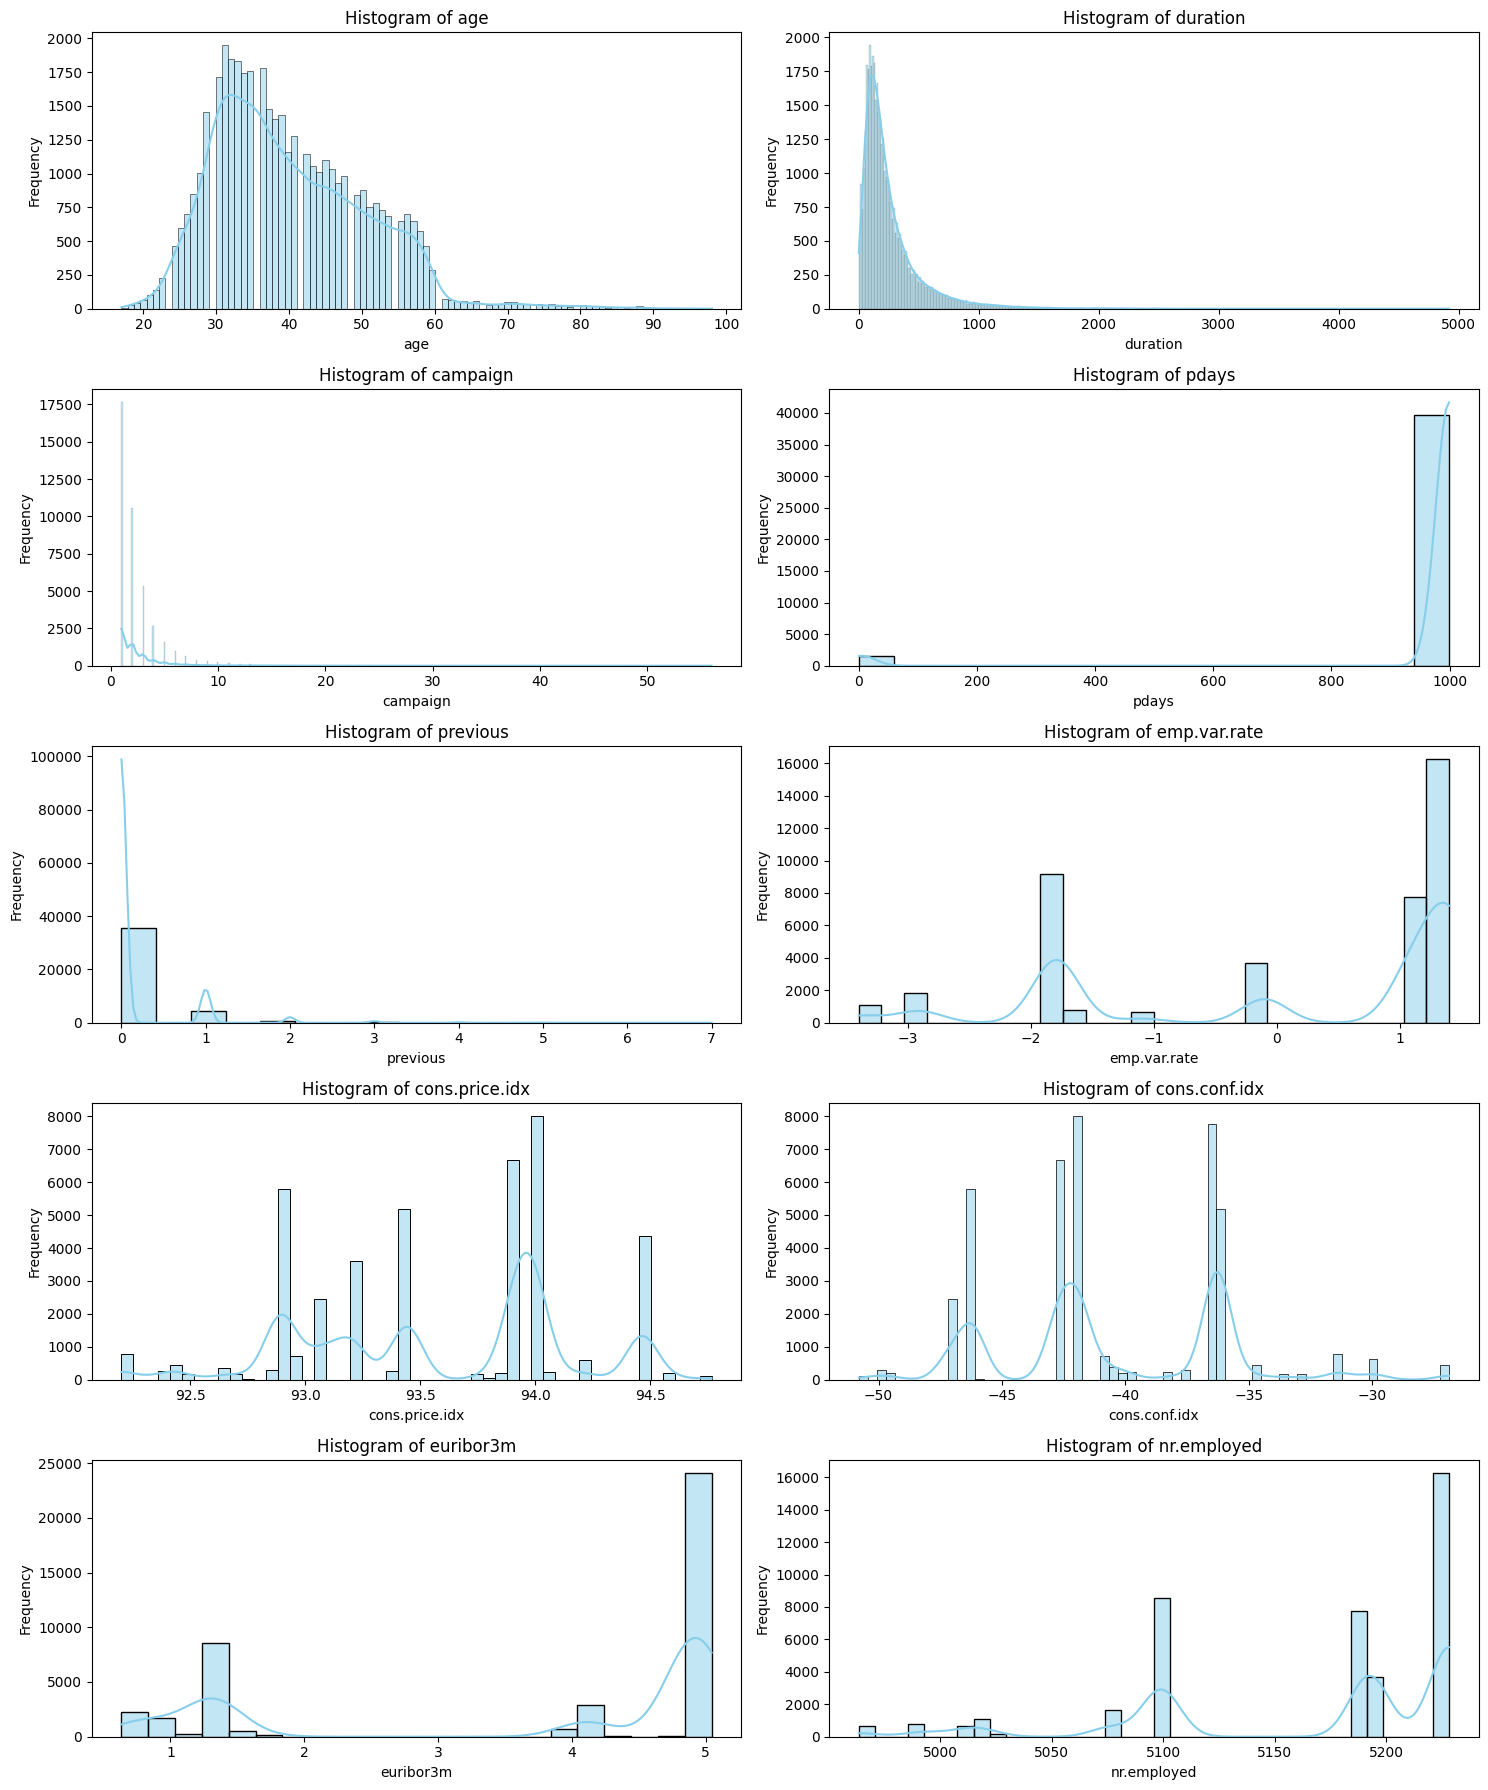

In [ ]:
# Nota: Dada a quantidade de gráficos, os mesmos são apresentados em pares. De notar que a escala não é igual em todos os graficos e como tal nao devem ser comparados diretamente.
# É apenas uma representação conjunta por uma questão de quantidade de variaveis

# Criar subplots para 5 linhas e 2 colunas uma vez que temos 10 variaveis numéricas
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))
for (i, j), col in zip(np.ndindex(axes.shape), df.select_dtypes(exclude='object').columns):
    ax = axes[i, j]
    sns.histplot(df[col], kde=True, ax=ax, color='skyblue')
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

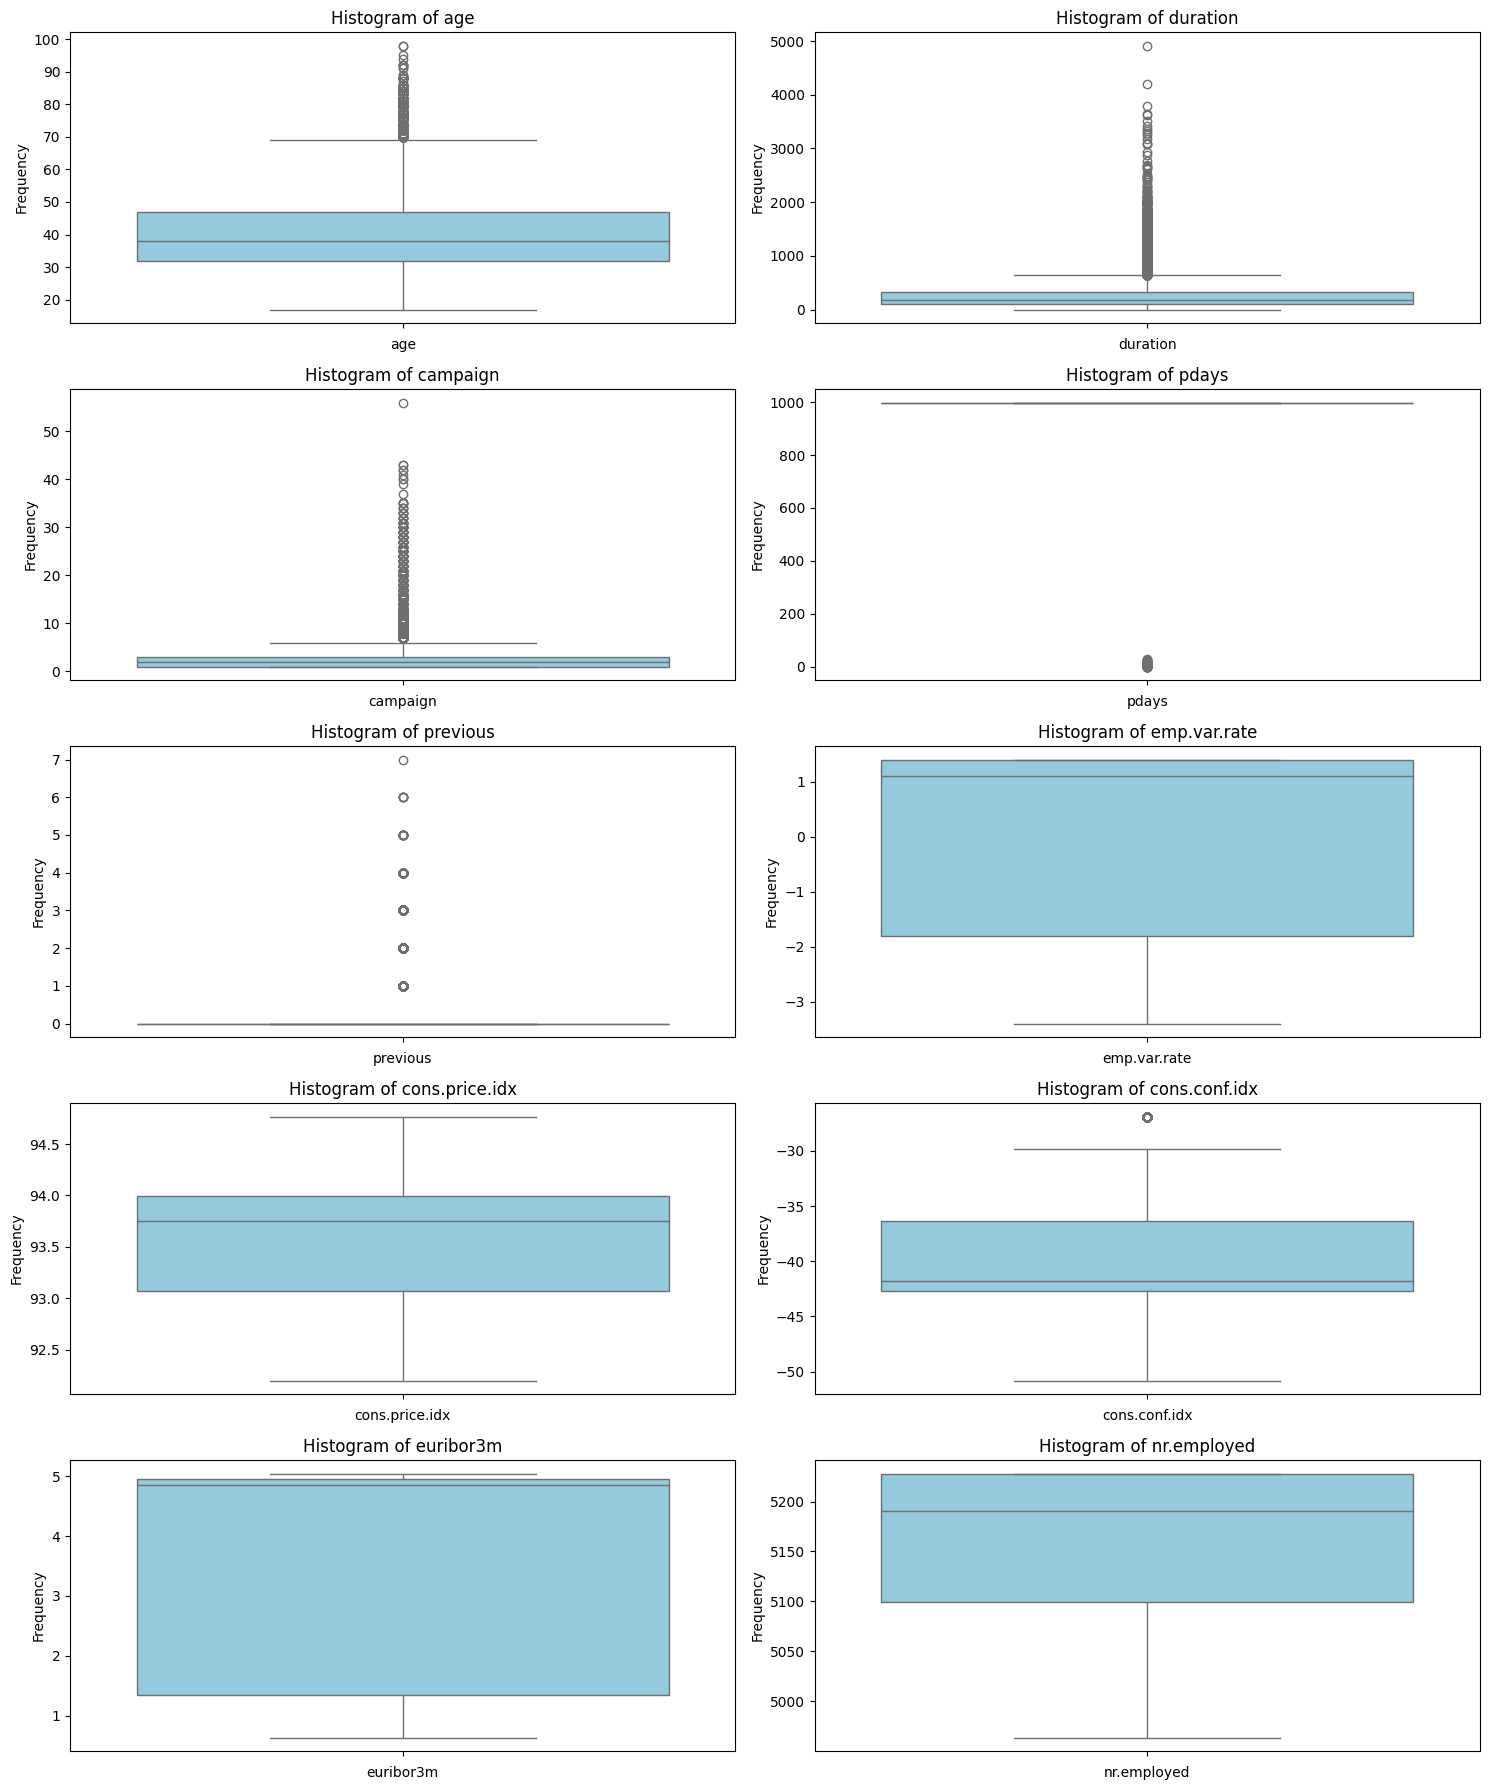

In [ ]:
# Nota: Dada a quantidade de gráficos, os mesmos são apresentados em pares. De notar que a escala não é igual em todos os graficos e como tal nao devem ser comparados diretamente.
# É apenas uma representação conjunta por uma questão de quantidade de variaveis

# Criar boxplots para as 10 variaveis númericas
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))
for (i, j), col in zip(np.ndindex(axes.shape), df.select_dtypes(exclude='object').columns):
    ax = axes[i, j]
    sns.boxplot(df[col], ax=ax, color='skyblue')
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

##### Categorical variables

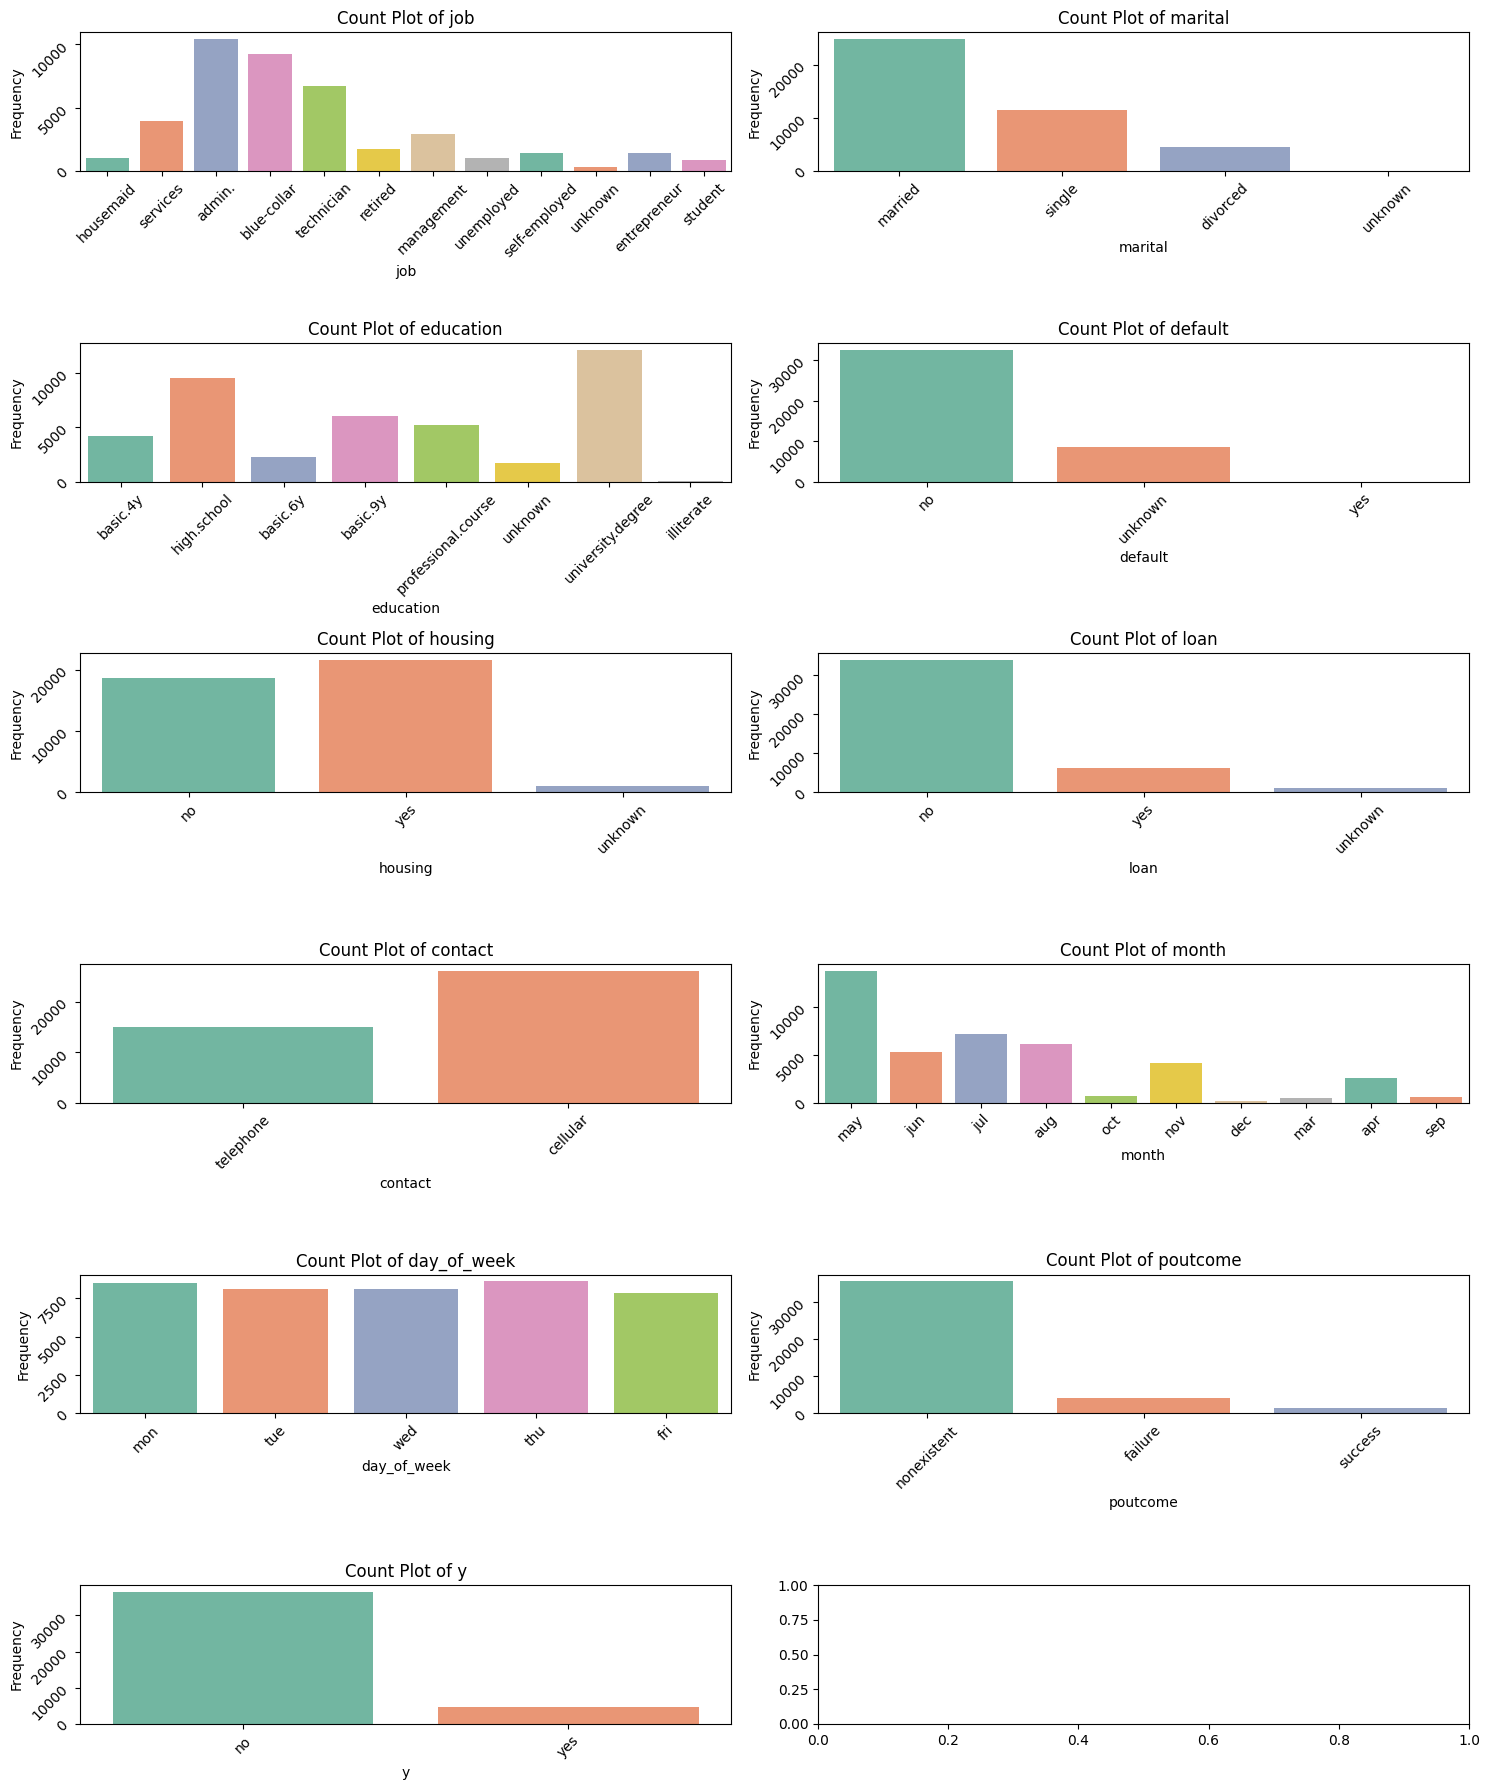

In [ ]:
# Nota: Dada a quantidade de gráficos, os mesmos são apresentados em pares. De notar que a escala não é igual em todos os graficos e como tal nao devem ser comparados diretamente.
# É apenas uma representação conjunta por uma questão de quantidade de variaveis

# Criar subplots para 6 linhas e 2 colunas uma vez que temos 11 variaveis categóricas
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 18))
for (i, j), col in zip(np.ndindex(axes.shape), df.select_dtypes(include='object').columns):
    ax = axes[i, j]
    sns.countplot(hue=col, x=col, data=df, ax=ax, palette="Set2", legend=False)
    ax.set_title(f'Count Plot of {col}')
    ax.tick_params(labelrotation=45)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Analise Bivariada

##### Numerica vs Numerica

###### ***Testes estatísticos***



In [ ]:
p_value = normaltest(df['age'])
print(p_value)

NormaltestResult(statistic=3902.5978596235364, pvalue=0.0)


- Uma vez que temos 41k+ linhas, shapiro-wilk nao se aplica. Poderemos aplicar apenas D'Agostino's K<sup>2</sup>
- Dadas as análises feitas previamente, apenas a variável age seria uma candidata a cumprir uma distribuição aproximadamente normal. No entanto tal como se pode observar, mesmo para esta variavel o valor de p_value é 0 pois a presença de distribuição normal nos valores da mesma é muito tenue.

###### ***Análise de correlação***

**Analise correlação - variáveis macroeconómicas**

Pearson - Tendo em conta as caracteristicas das variáveis númericas, apenas a feature "age" tem uma distribuição aproximadamente distribuida com um número baixo de outliers, não sendo no entanto relevante o suficiente para ser considerada uma distribuição normal pelo teste de D'Agostino K<sup>2</sup>. Desta forma, concluimos que nesta análise nao faz sentido a utilização do coeficiente de pearson


Kendall Tau e Spearman - Devemos aplicar apenas a variáveis que possam ser consideradas ordinais e sobre as quais tenhamos interesse em fazer alguma analise. Exemplo: age, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed, campaign, duration

In [ ]:
# Existe relação entre as variáveis a taxa de emprego e o número de pessoas empregadas?
spearman_corr, _ = spearmanr(df["emp.var.rate"], df["nr.employed"]) # relação monotona quase perfeita
kendall_corr, _ = kendalltau(df["emp.var.rate"], df["nr.employed"]) # forte concordancia nos ranks
distance_corr = correlation(df["emp.var.rate"], df["nr.employed"]) # dependencia positiva (ainda que nao perfeita)
mi = mutual_info_regression(df[["emp.var.rate"]].values, df["nr.employed"]) # existe alguma partilha/overlap de informação entre as 2 colunas

print("Spearman: ", spearman_corr)
print("Kendall: ", kendall_corr)
print("Distance: ", distance_corr)
print("Mutual Info: ", mi)

Spearman:  0.9446874287648435
Kendall:  0.8451002483178448
Distance:  0.09305050148203986
Mutual Info:  [1.61706334]


Existe uma correlação positiva entre as variaveis emp.var.rate e nr.employed, como podemos confirmar pelos resultados acima:

- Relação monótona quase perfeita
- Alguma concordância
- Dependência positiva (ainda que não perfeita)
- Existe alguma partilha/overlap de informação entre 2 colunas ainda que nao seja muito elevado

**Para evitar extender demasiado o relatório as seguintes análises foram apenas incluidas no notebook**

In [ ]:
# Existe uma relação entre a taxa de emprego e o valor da euribor?
spearman_corr, _ = spearmanr(df["emp.var.rate"], df["euribor3m"]) # relação monotona quase perfeita
kendall_corr, _ = kendalltau(df["emp.var.rate"], df["euribor3m"]) # alguma corcordancia
distance_corr = correlation(df["emp.var.rate"], df["euribor3m"]) # dependencia positiva (quase perfeita)
mi = mutual_info_regression(df[["emp.var.rate"]].values, df["euribor3m"]) # existe alguma partilha/overlap de informação entre as 2 colunas

print("Spearman: ", spearman_corr)
print("Kendall: ", kendall_corr)
print("Distance: ", distance_corr)
print("Mutual Info: ", mi)

Spearman:  0.9399146600283776
Kendall:  0.8275987126292552
Distance:  0.02775616902024347
Mutual Info:  [1.56617054]


Existe uma correlação positiva entre as variaveis emp.var.rate e euribor, como podemos confirmar pelos resultados acima:

- Relação monótona quase perfeita
- Alguma concordância
- Dependência positiva quase perfeita
- Existe alguma partilha/overlap de informação entre 2 colunas ainda que nao seja muito elevado

In [ ]:
# Existe alguma relação entre o indice do consumidor e o indice de confiança?
spearman_corr, _ = spearmanr(df["cons.price.idx"], df["cons.conf.idx"]) # sem relação monotona
kendall_corr, _ = kendalltau(df["cons.price.idx"], df["cons.conf.idx"]) # sem relação
distance_corr = correlation(df["cons.price.idx"], df["cons.conf.idx"]) # nenhuma dependencia
mi = mutual_info_regression(df[["cons.price.idx"]].values, df["cons.conf.idx"]) # existe alguma partilha/overlap de informação entre as 2 colunas

print("Spearman: ", spearman_corr)
print("Kendall: ", kendall_corr)
print("Distance: ", distance_corr)
print("Mutual Info: ", mi)

Spearman:  0.24577097225879643
Kendall:  0.1551090595371233
Distance:  0.9408298621067939
Mutual Info:  [2.38649857]


A correlação entre cons.price.idx e cons.conf.idx é fraca, embora exista alguma partilha/overlap de informação que pode ser relevante preservar

In [ ]:
# Existe alguma relação entre o indice do consumidor e o valor da euribor?
spearman_corr, _ = spearmanr(df["cons.price.idx"], df["euribor3m"]) # relação monotona fraca
kendall_corr, _ = kendalltau(df["cons.price.idx"], df["euribor3m"]) # relação entre ranks fraca
distance_corr = correlation(df["cons.price.idx"], df["euribor3m"]) # pouca dependencia
mi = mutual_info_regression(df[["cons.price.idx"]].values, df["euribor3m"]) # existe alguma partilha/overlap de informação entre as 2 colunas

print("Spearman: ", spearman_corr)
print("Kendall: ", kendall_corr)
print("Distance: ", distance_corr)
print("Mutual Info: ", mi)

Spearman:  0.4909447488120549
Kendall:  0.3523722856965091
Distance:  0.3118202274361953
Mutual Info:  [2.14361692]


A correlação entre cons.price.idx e euribor3m é fraca, embora exista alguma partilha/overlap de informação que pode ser relevante preservar

In [ ]:
# Existe alguma relação entre o índice de confiança e o valor da euribor?
spearman_corr, _ = spearmanr(df["cons.conf.idx"], df["euribor3m"]) # sem relação monotona
kendall_corr, _ = kendalltau(df["cons.conf.idx"], df["euribor3m"]) # sem concordancia/discordancia
distance_corr = correlation(df["cons.conf.idx"], df["euribor3m"]) # nenhuma dependencia
mi = mutual_info_regression(df[["cons.conf.idx"]].values, df["euribor3m"]) # existe alguma partilha/overlap de informação entre as 2 colunas

print("Spearman: ", spearman_corr)
print("Kendall: ", kendall_corr)
print("Distance: ", distance_corr)
print("Mutual Info: ", mi)

Spearman:  0.23679039363692184
Kendall:  0.17408486473530566
Distance:  0.7221358273731711
Mutual Info:  [2.13859327]


A correlação entre cons.conf.idx e euribor3m é fraca, embora exista alguma partilha/overlap de informação que pode ser relevante preservar

**Análise correlação - variáveis específicas do contexto**

In [ ]:
# Existe alguma relação entre a duração da chamada e a idade da pessoa contactada (potencial cliente)?
spearman_corr, _ = spearmanr(df["duration"], df["age"]) # sem relação monotona
kendall_corr, _ = kendalltau(df["duration"], df["age"]) # sem concordancia/discordancia
distance_corr = correlation(df["duration"], df["age"]) # nenhuma dependencia
mi = mutual_info_regression(df[["duration"]].values, df["age"]) # partilha/overlap de informação é muito reduzida

print("Spearman: ", spearman_corr)
print("Kendall: ", kendall_corr)
print("Distance: ", distance_corr)
print("Mutual Info: ", mi)

Spearman:  -0.002017365845098164
Kendall:  -0.0013862851517599632
Distance:  1.0008084134213706
Mutual Info:  [0.0038086]


A correlação entre duration e age é praticamente nula em todas as análises sendo que a informação mútua também se revela praticamente nula. Estas duas variáveis não aparentam ter nenhuma relação entre si

In [ ]:
# Existe alguma relação entre o número de vezes um potencial cliente foi contactado e a sua idade?
spearman_corr, _ = spearmanr(df["campaign"], df["age"]) # sem relação monotona
kendall_corr, _ = kendalltau(df["campaign"], df["age"]) # sem concordancia/discordancia
distance_corr = correlation(df["campaign"], df["age"]) # nenhuma dependencia
mi = mutual_info_regression(df[["campaign"]].values, df["age"]) # partilha/overlap de informação é muito reduzida

print("Spearman: ", spearman_corr)
print("Kendall: ", kendall_corr)
print("Distance: ", distance_corr)
print("Mutual Info: ", mi)

Spearman:  0.005753831302204701
Kendall:  0.004352695551084114
Distance:  0.9953784455951787
Mutual Info:  [0]


A correlação entre campaign e age é praticamente nula em todas as análises sendo que a informação mútua também se revela praticamente nula. Estas duas variáveis não aparentam ter nenhuma relação entre si

In [ ]:
# Existe alguma relação entre o número de vezes um potencial cliente foi contactado e a duração das chamadas?
spearman_corr, _ = spearmanr(df["campaign"], df["duration"]) # sem relação monotona
kendall_corr, _ = kendalltau(df["campaign"], df["duration"]) # sem concordancia/discordancia
distance_corr = correlation(df["campaign"], df["duration"]) # nenhuma dependencia
mi = mutual_info_regression(df[["campaign"]].values, df["duration"]) # # partilha/overlap de informação é muito reduzida

print("Spearman: ", spearman_corr)
print("Kendall: ", kendall_corr)
print("Distance: ", distance_corr)
print("Mutual Info: ", mi)

Spearman:  -0.08110104465699933
Kendall:  -0.06015007488466267
Distance:  1.0717646840538158
Mutual Info:  [0.03495766]


A correlação entre campaign e duration é praticamente nula em todas as análises sendo que a informação mútua também se revela praticamente nula. Estas duas variáveis não aparentam ter nenhuma relação entre si

Resumo:
- As variáveis macroeconómicas têm claramente uma correlação muito mais forte entre si do que as variáveis específicas relativas à campanha ou ao cliente (duration, age, campaign)
- Teremos que validar como estas variáveis se relacionam com a variável target para perceber a sua importância

##### Numerica vs Categorica

###### **Análise das colunas a remover**

In [ ]:
#Existe alguma relação entre o número de dias decorridos desde o último contacto relativo a outra camapnha (pdays) e a variável a prever (y)?
le = LabelEncoder() # y é binaria, podemos fazer label encoding
numeric_binary_y = le.fit_transform(df['y'])

biserial_stat, biserial_p_value = pointbiserialr(numeric_binary_y, df["pdays"])
if (biserial_p_value < 0.05):
  print("As variáveis estão correlacionadas")
else:
  print("As variáveis não estão correlacionadas")

mi = mutual_info_classif(df[["pdays"]], df["y"])

print(f"Biserial Stat: {biserial_stat}, P-Value: {biserial_p_value}")
print("Mutual Info: ", mi)

As variáveis estão correlacionadas
Biserial Stat: -0.3249475863855851, P-Value: 0.0
Mutual Info:  [0.04078636]


- correlação negativa entre as variáveis
- informação mútua é muito baixa

* Conclusão: A variável pdays não contém uma quantidade relevante de informação para a previsão. Uma vez que o número de valores em falta/999 desta variável é quase de 100% (é muito arriscado tentar preencher/inferir os valores desta mesma variável) e a sua relevância para a previsão é baixa => Podemos remover

In [ ]:
df.drop(columns=['pdays'], inplace=True)

In [ ]:
#Existe alguma relação entre o número de contactos desde o último contacto relativo a outra campanha (previous) e a variável a prever (y)?
le = LabelEncoder()
numeric_binary_y = le.fit_transform(df['y'])

biserial_stat, biserial_p_value = pointbiserialr(numeric_binary_y, df["previous"])
if (biserial_p_value < 0.05):
  print("As variáveis estão correlacionadas")
else:
  print("As variáveis não estão correlacionadas")

mi = mutual_info_classif(df[["previous"]], df["y"])

print(f"Biserial Stat: {biserial_stat}, P-Value: {biserial_p_value}")
print("Mutual Info: ", mi)

As variáveis estão correlacionadas
Biserial Stat: 0.2302015702154478, P-Value: 0.0
Mutual Info:  [0.0201326]


- correlação positiva entre as variáveis
- informação mútua é muito baixa
- Conclusão: A variável previous não contém uma quantidade relevante de informação para a previsão. Uma vez que o número de valores em falta/0 desta variável é quase de 90% (é muito arriscado tentar preencher/inferir os valores desta mesma variável) e a sua relevância é baixa => Podemos remover

In [ ]:
df.drop(columns=['previous'], inplace=True)

###### **Outras correlações**

In [ ]:
# O valor da euribor tem efeito no probabilidade de um cliente aderir ao produto (depoósito a prazo)?
biserial_stat, biserial_p_value = pointbiserialr(numeric_binary_y, df["euribor3m"])
if (biserial_p_value < 0.05):
  print("As variáveis estão correlacionadas")
else:
  print("As variáveis não estão correlacionadas")

mi = mutual_info_classif(df[["euribor3m"]], df["y"])

print(f"Biserial Stat: {biserial_stat}, P-Value: {biserial_p_value}")
print("Mutual Info: ", mi)

As variáveis estão correlacionadas
Biserial Stat: -0.30774039558468924, P-Value: 0.0
Mutual Info:  [0.07503522]


- ligeira correlação entre y e euribor3m
- correlação negativa: indica que quando euribor3m cresce o y tende a ser 0 ('n')
- no contexto: Isto pode ser explicado por factos macroeconómicos, uma vez que variando a taxa diretora apesar de tendencialmente a taxa paga por depósitos a prazo também aumentar existem outros fatores como variações na taxa de emprego (como vimos anteriormente) ou até potencialmente o valor do aumento dos creditos à habitação, que faz com que as oessoas estejam mais reticentes a aderir a depósitos pois têm que fazer face aos aumentos económicos noutros factores da sua vida

In [ ]:
# O valor da duração da chamada tem efeito no probabilidade de um cliente aderir ao produto (depoósito a prazo)?
biserial_stat, biserial_p_value = pointbiserialr(numeric_binary_y, df["duration"])
if (biserial_p_value < 0.05):
  print("As variáveis estão correlacionadas")
else:
  print("As variáveis não estão correlacionadas")

mi = mutual_info_classif(df[["duration"]], df["y"])

print(f"Biserial Stat: {biserial_stat}, P-Value: {biserial_p_value}")
print("Mutual Info: ", mi)

As variáveis estão correlacionadas
Biserial Stat: 0.405297261268526, P-Value: 0.0
Mutual Info:  [0.07492881]


- correlação positiva entre duration e y
- ligeira tendência para chamadas com mais duração tenderem a resultar em y com valor 1 ('y')

In [ ]:
# A idade do cliente tem efeito no probabilidade de aderir ao produto (depoósito a prazo)?
biserial_stat, biserial_p_value = pointbiserialr(numeric_binary_y, df["age"])
if (biserial_p_value < 0.05):
  print("As variáveis estão correlacionadas")
else:
  print("As variáveis não estão correlacionadas")

mi = mutual_info_classif(df[["age"]], df["y"])

print(f"Biserial Stat: {biserial_stat}, P-Value: {biserial_p_value}")
print("Mutual Info: ", mi)

As variáveis estão correlacionadas
Biserial Stat: 0.03038053621987592, P-Value: 7.003243845943233e-10
Mutual Info:  [0.01349383]


- correlação positiva entre age e y (embora esta correlação seja tão fraca que pode ser desprezivel)

##### Categorica vs categorica

In [ ]:
# Analisar o grau de dependencia das features categorias relativamente à variavel objetivo ("y")
categorical_cols = df.select_dtypes(include=["object"]).columns

for col in categorical_cols:
    if col != "y":
        tabela_contingencia = pd.crosstab(df[col], df["y"])
        chi2 = chi2_contingency(tabela_contingencia)  # Teste Qui-Quadrado
        if(chi2.pvalue < 0.05):
          print(f"Variavel {col} não é independente de y, com p_value: {chi2.pvalue} e chi2 statistic: {chi2.statistic}")
        else:
          print(f"Variável {col} pode ser independente de y, com p_value: {chi2.pvalue} e chi2 statistic: {chi2.statistic}")

        col_labeled = LabelEncoder().fit_transform(df[col]).reshape(-1, 1)
        mi = mutual_info_classif(col_labeled, df["y"])
        print(f"Informação mútua entre y e variável {col}: {mi}")

        if (chi2.pvalue < 0.05): # cramer's V - apenas se o teste de qui-quadrado for significativo
          n = tabela_contingencia.sum().sum()
          k, r = tabela_contingencia.shape
          v_cramer = np.sqrt(chi2.statistic / (n * min(k - 1, r - 1)))
          print(f"Cramer's V entre variável y e {col}: {v_cramer} \n")
        else
          print("\n")

Variavel job não é independente de y, com p_value: 3.2684116066165443e-199 e chi2 statistic: 961.7438037353177
Informação mútua entre y e variável job: [0.01071092]
Cramer's V entre variável y e job: 0.15282965081945582 

Variavel marital não é independente de y, com p_value: 1.7784225004611415e-26 e chi2 statistic: 122.95931379226255
Informação mútua entre y e variável marital: [0.00257034]
Cramer's V entre variável y e marital: 0.05464603271418174 

Variavel education não é independente de y, com p_value: 3.746768377534744e-38 e chi2 statistic: 192.8485047401879
Informação mútua entre y e variável education: [0.00417155]
Cramer's V entre variável y e education: 0.06843622733946123 

Variavel default não é independente de y, com p_value: 5.2175408937279634e-89 e chi2 statistic: 406.5560941574606
Informação mútua entre y e variável default: [0.00779944]
Cramer's V entre variável y e default: 0.09936608065719632 

Variável housing pode ser independente de y, com p_value: 0.0566379274945

In [ ]:
df.drop(columns=['poutcome'], inplace=True)

**Heatmap - Overview**

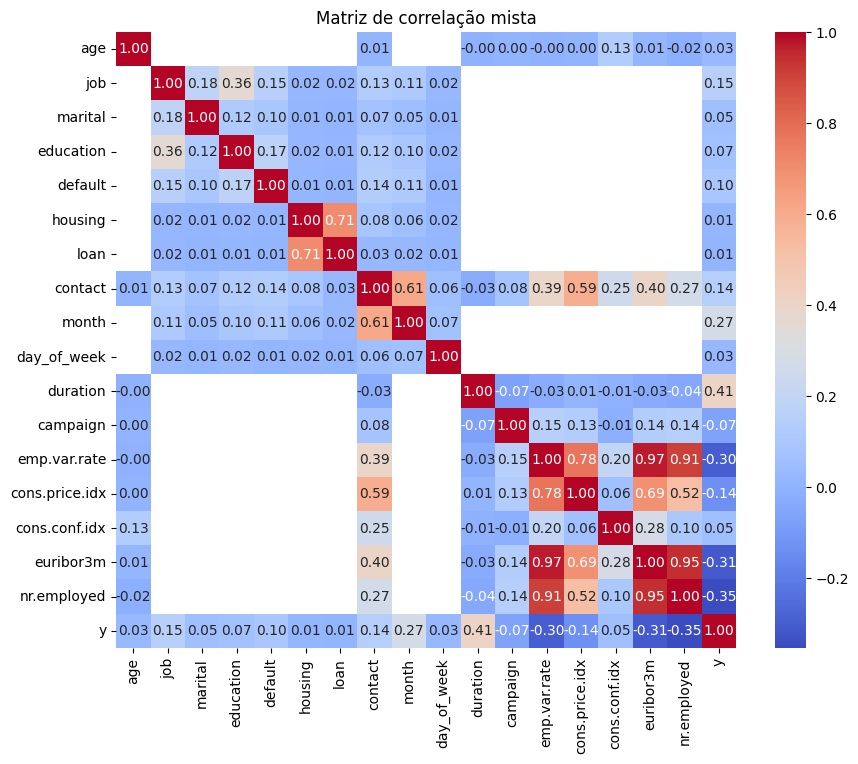

In [ ]:
def cramers_v(contingency_table):
  '''
  Função para calcular o Cramér's V para variáveis categóricas
  '''
  chi2, _, _, _ = chi2_contingency(contingency_table)
  n = contingency_table.sum().sum()
  k, r = contingency_table.shape
  return np.sqrt(chi2 / (n * (min(k - 1, r - 1))))
def mixed_correlation_matrix(df):
  '''
  Função para calcular a matriz de correlação para vários tipo de dados
  '''
  correlation_matrix = pd.DataFrame(index=df.columns, columns=df.columns)
  for col1 in df.columns:
    for col2 in df.columns:
      if df[col1].dtype == 'category':
        if df[col2].dtype == 'category':
          # Categorica-Categorica: Usar Cramér's V
          contingency_table = pd.crosstab(df[col1], df[col2])
          correlation_matrix.loc[col1, col2] = cramers_v(contingency_table)
        else:
          # Categorica-Numerica: Usar Correlação Bisserial
          if df[col1].nunique() == 2: # Apenas válido para variáveis binárias e têm de estar codificadas
            encoded_col = pd.get_dummies(df[col1], drop_first=True).iloc[:, 0]
            correlation_matrix.loc[col1, col2] = pointbiserialr(encoded_col, df[col2])[0]
          else:
            correlation_matrix.loc[col1, col2] = np.nan
      elif df[col2].dtype == 'category':
        if df[col2].nunique() == 2: # Apenas válido para variáveis binárias e têm de estar codificadas
          encoded_col = pd.get_dummies(df[col2], drop_first=True).iloc[:, 0]
          correlation_matrix.loc[col1, col2] = pointbiserialr(encoded_col, df[col1])[0]
        else:
          correlation_matrix.loc[col1, col2] = np.nan
      else:
        # Numerica-Numerica: Usar Pearson Correlation por exemplo
        correlation_matrix.loc[col1, col2] = df[col1].corr(df[col2])

  return correlation_matrix.astype(float)


# Algumas variáveis categóricas podem estar como tipo 'object', por isso, para simplificar
# convertemos para 'category'. Verificar primeiro se de facto as variáveis do tipo 'object' são categóricas
for col in df.select_dtypes(include='object').columns:
  df[col] = df[col].astype('category')

# Calcular a matriz de correlação com uma função customizada
corr_matrix = mixed_correlation_matrix(df)

# Fazer o gráfico
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matriz de correlação mista")
plt.show()

### Fase 5 - Tratar de outliers e dados ausentes

#### Dados ausentes

Após a analise e remoção das colunas previous, pdays e poutcome, temos agora que analisar os restantes dados ausentes nas restantes colunas. Esta análise terá que ser mais detalhada para perceber como deveremos preencher os valores em falta, mantendo a validade dos dados

In [ ]:
df['age'].unique()

array([56, 57, 37, 40, 45, 59, 41, 24, 25, 29, 35, 54, 46, 50, 39, 30, 55,
       49, 34, 52, 58, 32, 38, 44, 42, 60, 53, 47, 51, 48, 33, 31, 43, 36,
       28, 27, 26, 22, 23, 20, 21, 61, 19, 18, 70, 66, 76, 67, 73, 88, 95,
       77, 68, 75, 63, 80, 62, 65, 72, 82, 64, 71, 69, 78, 85, 79, 83, 81,
       74, 17, 87, 91, 86, 98, 94, 84, 92, 89])

In [ ]:
# Substituir unknowns por Nan
df_copy = df.copy()
df_copy.replace('unknown', np.nan, inplace=True)
# validar os nulos por coluna
null_counts = df_copy.isnull().sum()
null_percentage = (null_counts / len(df)) * 100

null_summary = pd.DataFrame({
    'Null Count': null_counts,
    'Null Percentage': null_percentage
})

print(null_summary)

                Null Count  Null Percentage
age                      0         0.000000
job                    330         0.801438
marital                 80         0.194288
education             1730         4.201477
default               8596        20.876239
housing                990         2.404313
loan                   990         2.404313
contact                  0         0.000000
month                    0         0.000000
day_of_week              0         0.000000
duration                 0         0.000000
campaign                 0         0.000000
emp.var.rate             0         0.000000
cons.price.idx           0         0.000000
cons.conf.idx            0         0.000000
euribor3m                0         0.000000
nr.employed              0         0.000000
y                        0         0.000000


<ipython-input-97-1250e2faaaee>:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df_copy.replace('unknown', np.nan, inplace=True)


In [ ]:
print(df[['default', 'loan', 'housing']].apply(pd.Series.value_counts))

         default   loan  housing
no         32577  33938    18615
unknown     8596    990      990
yes            3   6248    21571


In [ ]:
df.drop(columns=['default'], inplace=True)

In [ ]:
df['job'] = df['job'].replace('unknown', df['job'].mode().iloc[0])
df['marital'] = df['marital'].replace('unknown', df['marital'].mode().iloc[0])
df['loan'] = df['loan'].replace('unknown', df['loan'].mode().iloc[0])
df['housing'] = df['housing'].replace('unknown', df['housing'].mode().iloc[0])

<ipython-input-100-b247b83861b7>:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['job'] = df['job'].replace('unknown', df['job'].mode().iloc[0])
<ipython-input-100-b247b83861b7>:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['marital'] = df['marital'].replace('unknown', df['marital'].mode().iloc[0])
<ipython-input-100-b247b83861b7>:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use 

In [ ]:
# esta abordagem demora demasiado tempo então decidimos não a fazer uma vez que o custo é superior ao beneficio que teriamos por usar LabelEncoder transformer
#job_encoded = le.fit_transform(df['job'])
#binary_default_encoded = le.fit_transform(df['default'])
#education_encoded = le.fit_transform(df['education'])

#imputer = IterativeImputer(estimator=RandomForestRegressor())
#df_filled_rf = imputer.fit_transform([job_encoded, df['age'], binary_default_encoded, education_encoded])

df['education'] = df['education'].replace('unknown', df['education'].mode().iloc[0])

<ipython-input-101-a13521be13c6>:10: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  df['education'] = df['education'].replace('unknown', df['education'].mode().iloc[0])


#### Outliers

- distância interquartil: iremos usar então este metodo estatistico para identificar os outliers
- como já verificamos inicialmente, existem várias colunas com alguns valores extremos. Para garantir que conseguimos fazer uma análise mantendo o máximo de firmação possível que possa ser considerada válida, decidimos utilizar um k=3 (extremo)

In [ ]:
df['age'].unique()

array([56, 57, 37, 40, 45, 59, 41, 24, 25, 29, 35, 54, 46, 50, 39, 30, 55,
       49, 34, 52, 58, 32, 38, 44, 42, 60, 53, 47, 51, 48, 33, 31, 43, 36,
       28, 27, 26, 22, 23, 20, 21, 61, 19, 18, 70, 66, 76, 67, 73, 88, 95,
       77, 68, 75, 63, 80, 62, 65, 72, 82, 64, 71, 69, 78, 85, 79, 83, 81,
       74, 17, 87, 91, 86, 98, 94, 84, 92, 89])

In [ ]:
# variaveis numericas
outliers_dict = {}
threshold_dict = {}
for i, col in enumerate(df.select_dtypes(include=np.number).columns):  # Calcular Q1, Q3 e IQR
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  # Definir os limites para outliers
  k = 3
  if (col in ['age', 'duration', 'campaign', 'nr.employed']):
    limite_inferior = max(Q1 - k * IQR, 0)
  else:
    limite_inferior = Q1 - k * IQR
  limite_superior = Q3 + k * IQR
  outliers_dict[col] = df[(df[col] < limite_inferior) | (df[col] > limite_superior)][col]
  threshold_dict[col] = {'inferior': limite_inferior, 'superior': limite_superior}
  print(f"Coluna {col} com {len(outliers_dict[col])} outliers, limite inferior: {limite_inferior} ; limite superior: {limite_superior}")


Coluna age com 4 outliers, limite inferior: 0 ; limite superior: 92.0
Coluna duration com 1043 outliers, limite inferior: 0 ; limite superior: 970.0
Coluna campaign com 1094 outliers, limite inferior: 0 ; limite superior: 9.0
Coluna emp.var.rate com 0 outliers, limite inferior: -11.400000000000002 ; limite superior: 11.000000000000002
Coluna cons.price.idx com 0 outliers, limite inferior: 90.31800000000001 ; limite superior: 96.75099999999999
Coluna cons.conf.idx com 0 outliers, limite inferior: -61.600000000000016 ; limite superior: -17.499999999999986
Coluna euribor3m com 0 outliers, limite inferior: -9.507 ; limite superior: 15.812
Coluna nr.employed com 0 outliers, limite inferior: 4712.1 ; limite superior: 5615.1


In [ ]:
for index in outliers_dict["age"].index:
  df.loc[index, "age"] = int(threshold_dict["age"]["inferior"]) if df.loc[index, "age"] < threshold_dict["age"]["inferior"] else threshold_dict["age"]["superior"]

In [ ]:
df_copy['age'].unique()

array([56, 57, 37, 40, 45, 59, 41, 24, 25, 29, 35, 54, 46, 50, 39, 30, 55,
       49, 34, 52, 58, 32, 38, 44, 42, 60, 53, 47, 51, 48, 33, 31, 43, 36,
       28, 27, 26, 22, 23, 20, 21, 61, 19, 18, 70, 66, 76, 67, 73, 88, 95,
       77, 68, 75, 63, 80, 62, 65, 72, 82, 64, 71, 69, 78, 85, 79, 83, 81,
       74, 17, 87, 91, 86, 98, 94, 84, 92, 89])

In [ ]:
df.loc[outliers_dict["campaign"].index, "campaign"] = df["campaign"].median()
df.loc[outliers_dict["duration"].index, "duration"] = df["duration"].median()

### Fase 6 - Transformação de dados

#### Discretização

Para criar "bins" para estas variáveis vamos usar discretização baseada em domínio uma vez que faz mais sentido tentar agrupar tendo por base aquilo que são padrões normais da sociedade:

- age: https://www.statcan.gc.ca/en/concepts/definitions/age2 - tendo por base os grupos definidos neste website governamental iremos então fazer as seguintes divisões (apesar de já não estar em uso oficial, da-nos uma ideia de como fazer uma divisão plausível):
    * youth (less than 24)
    * adult (25 to 64)
    * senior (65 or more)

- education: tendo por base os niveis de escolaridade em Portugal iremos considerar os seguintes níveis:
    * illiterate (illiterate)
    * basic (basic.4y, basic.6y, basic.9y)
    * high_school (high.school, professional.course)
    * university (university.degree)


In [ ]:
#age
bins = [0, 24, 64, 100]
labels = ['youth', 'adult', 'senior']

df['age'] = pd.cut(df_copy['age'], bins=bins, labels=labels, include_lowest=True)

In [ ]:
df['age'].unique()

['adult', 'youth', 'senior']
Categories (3, object): ['youth' < 'adult' < 'senior']

In [ ]:
#education

education_categories_ordered = ['illiterate', 'basic', 'high_school', 'university']
education_mapping = {
    'illiterate': 'illiterate',
    'basic.4y': 'basic',
    'basic.6y': 'basic',
    'basic.9y': 'basic',
    'high.school': 'high_school',
    'professional.course': 'high_school',
    'university.degree': 'university'
}

df['education'] = df['education'].map(education_mapping)
df['education'] = pd.Categorical(df['education'],
                                 categories=education_categories_ordered,
                                 ordered=True)

In [ ]:
df.to_csv("final_aed.csv", index=False)

#### Padronização

##### Numerical variables

- age: we will use Standardization as this variable tends to follow a normal distribution
- duration and campaign: as we saw in the description above these coluns contained some outliers even tho we were only looking for real extreme values. Therefore to avoid extreme values we decided to use a 'escalonamento robusto'
- cons.price.idx, euribor3m, nr.employed: sendo valores unicamente positivos e tendo presença de alguns outliers, iremos utilizar min-max
- emp.var.rate and cons.conf.idx: although not having extreme outliers, these variables contain negative values (so min-max is not a good choice) and do not follow a normal distribution (StandardScaler also not the best option), so we decided to follow RobustScaler for these

In [ ]:
# Define the scalers
scalers = {
    "duration": RobustScaler(),
    "campaign": RobustScaler(),
    "emp.var.rate": RobustScaler(),
    "cons.conf.idx": RobustScaler(),
    "cons.price.idx": MinMaxScaler(),
    "euribor3m": MinMaxScaler(),
    "nr.employed": MinMaxScaler(),
}

# Apply scaling
for feature, scaler in scalers.items():
    df[feature] = scaler.fit_transform(df[[feature]])

##### Categorical variables

- job, marital: uma vez que estas variáveis não têm qualquer tipo de ordem entre as diferentes categorias, iremos utilizar one-hot encoding
- education: uma vez que as diferntes categorias de education estabelecem entre si uma certa relação de ordem (illiterate < basic < high_school< university), iremos recorrer a ordinal encoding
- age: após criação dos bins esta variável tornou-se categórica com ordem entre as suas categorias (youth < adult < senior) por isso utilizaremos ordinal encoding
- housing and loan and y and contact: uma vez que estas variaveis sao binárias, não se coloca o problema da existencia de ordenação uma vez que só temos 2 valores possíveis. Assim iremos utilizar label encoding
- day_of_week: day_of_week seem to follow an order Monday, Tuesday, .... However, since the distance between Friday and Monday is the same as the distance between Monday and Tuesday it does not make sense to use ordinal encoding. So we will following the one hot encoding
- month: similarly to day_of_week we will use here one hot encoding

In [ ]:
# housing, loan, contact, y - label encoding
for col in ["housing", "loan", "contact", "y"]:
    df[col] = LabelEncoder().fit_transform(df[col])

In [ ]:
# job, marital, month, day_of_week - one hot encoding
df = pd.get_dummies(df, columns=["job", "marital", "month", "day_of_week"])

In [ ]:
# education - ordinal encoding
df["education"] = OrdinalEncoder().fit_transform(df[["education"]])

In [ ]:
# age - ordinal encoding
df["age"] = OrdinalEncoder().fit_transform(df[["age"]])

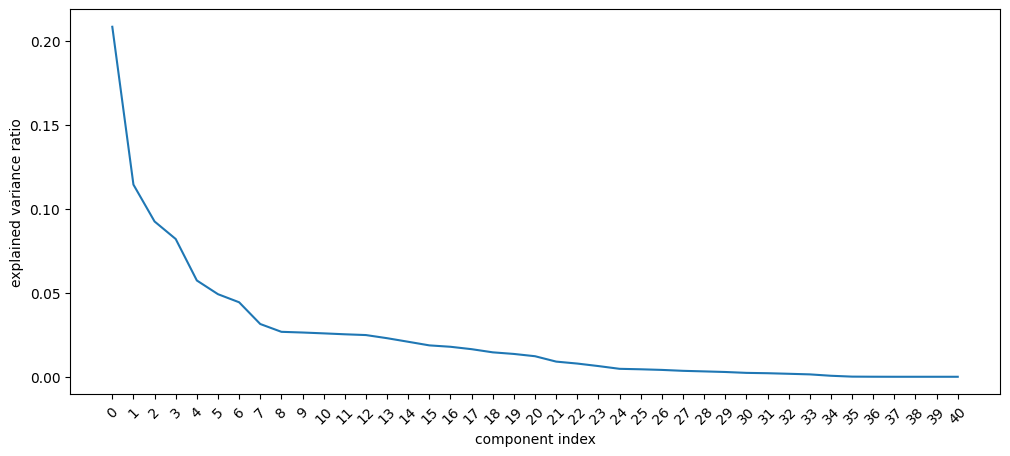

In [ ]:
df_for_pca = df.drop(columns=['y']).copy()
pca = PCA().fit(df_for_pca)  # Using the already standardized data

# Visualizar scree plot
plt.figure(figsize=(12, 5))
plt.plot(pca.explained_variance_ratio_, linestyle='-')
plt.xticks(range(len(pca.explained_variance_ratio_)), rotation=45)
plt.xlabel("component index")
plt.ylabel("explained variance ratio")
plt.show()

Analisando o scree plot vemos que o ponto de cotovelo está nos 8 componentes. Dessa forma podemos então definir 8 como o número de componentes necessários para incluir toda a informação necessária recorrendo ao uso do modelo PCA

Percentagem de variância explicada: 0.6793523549297208


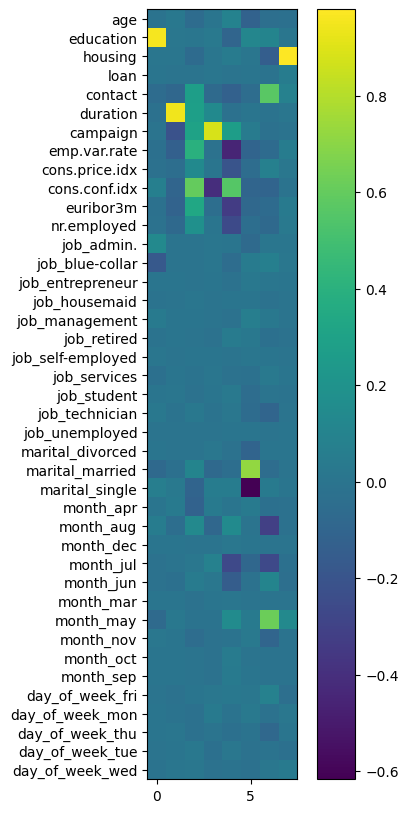

In [ ]:
 # Apply PCA with 8 components
pca = PCA(n_components=8)
df_for_pca = df.drop(columns=['y']).copy()
X_pca = pca.fit_transform(df_for_pca)  # Using the already standardized data
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'])
df_pca['y'] = df['y'].values

print(f"Percentagem de variância explicada: {np.sum(pca.explained_variance_ratio_)}")
# Visualizar importância das variáveis na definição dascomponentes
components = pca.components_
plt.figure(figsize=(5, 10))
plt.imshow(components.T)
plt.yticks(range(len(df_for_pca.columns)),
df_for_pca.columns)
plt.colorbar()
plt.show()

Variáveis que explicam a maioria da variância:

Variáveis específicas do contexto:
- education, housing, duration, campaign

Variáveis macroeconómicas relevantes:
- cons.conf.idx,euribor3m

In [ ]:
df_pca.to_csv("final_pca.csv", index=False)

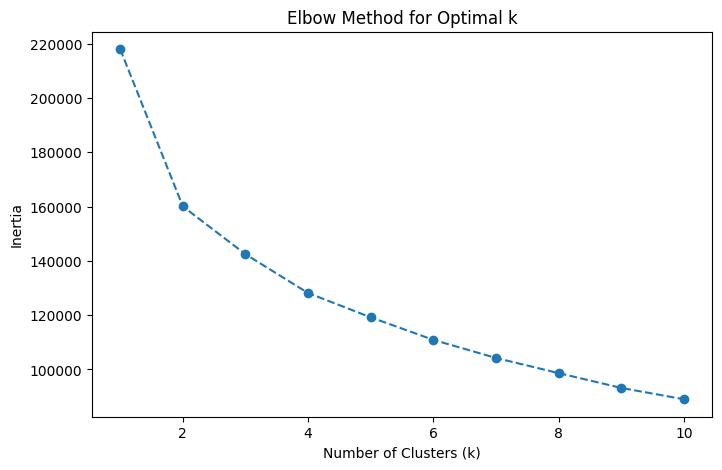

In [ ]:
# Try different values of k
inertia = []
K_range = range(1, 11)  # Test k from 1 to 10

df_pca_no_y = df_pca.drop(columns=['y']).copy()
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit(df_pca_no_y)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

Analisando o gráfico conseguimos perceber que o número de clusters ideal para refletir uma boa divisão dos dados se situa entre 3 e 4. Iremos então escolher 3

In [ ]:
# Fit K-Means model
kmeans = KMeans(n_clusters=3, random_state=42)
df_pca_no_y["cluster"] = kmeans.fit_predict(df_pca_no_y)

distribution_percent = pd.crosstab(df_pca_no_y['cluster'], df_pca['y'], normalize='index')
print(distribution_percent)

y               0         1
cluster                    
0        0.861747  0.138253
1        0.787736  0.212264
2        0.963406  0.036594


### Machine Learning

In [ ]:
def get_metrics_dataframe(model_name,
                          y_train, y_pred_train, y_prob_train,
                          y_test, y_pred_test, y_prob_test,
                          best_params, fit_time):
    train_report = classification_report(y_train, y_pred_train, output_dict=True)
    test_report = classification_report(y_test, y_pred_test, output_dict=True)

    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)

    # calcular AUC se probabilidade foi calculada para o modelo
    auc_train = roc_auc_score(y_train, y_prob_train) if y_prob_train is not None else None
    auc_test = roc_auc_score(y_test, y_prob_test) if y_prob_test is not None else None

    class_mapping = {'0': 'n', '1': 'y'}

    rows = []
    for classe in ['0', '1']:
        # Linha relativa ao treino
        rows.append({
            "Model": model_name,
            "Train/Test": "Train",
            "Class": class_mapping.get(classe, classe),
            "Precision": train_report[classe]['precision'],
            "Recall": train_report[classe]['recall'],
            "F1-Score": train_report[classe]['f1-score'],
            "Support": train_report[classe]['support'],
            "Accuracy": accuracy_train,
            "Macro Avg": train_report['macro avg']['f1-score'],
            "Weighted Avg": train_report['weighted avg']['f1-score'],
            "Best params": best_params,
            "AUC": auc_train,
            "Fit Elapsed Time": fit_time
        })
        # Linha relativa ao teste
        rows.append({
            "Model": model_name,
            "Train/Test": "Test",
            "Class": class_mapping.get(classe, classe),
            "Precision": test_report[classe]['precision'],
            "Recall": test_report[classe]['recall'],
            "F1-Score": test_report[classe]['f1-score'],
            "Support": test_report[classe]['support'],
            "Accuracy": accuracy_test,
            "Macro Avg": test_report['macro avg']['f1-score'],
            "Weighted Avg": test_report['weighted avg']['f1-score'],
            "Best params": best_params,
            "AUC": auc_test,
            "Fit Elapsed Time": fit_time
        })

    return pd.DataFrame(rows)

In [ ]:
def model_evaluation(true, pred):
    cm = confusion_matrix(true, pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    plt.show()
    print(classification_report(true, pred))


def split_dataset(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return train_test_split(X, y, test_size=0.2, random_state=42)

def train_models(models, X_train, y_train, X_test, y_test):
    best_models = {}
    stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results_df = pd.DataFrame()

    for name, (model, params) in models.items():
        start_time = time.time()
        grid = GridSearchCV(model, params, cv=stratified_kfold, scoring='average_precision', n_jobs=-1) # StratifiedKFold(n_splits=5) - como o dataset está muito desbalanceado esta estratégia de cross validation ajuda a garantir a proporção de dados do dataset é transmitida na divisão em folds; scoring="average_precision" como o dataset é altamente desbalanceado e pretende-se ainda que de forma balanceada com o precision, ter um valor de recall alto para garantir que nao perdemos potenciais clientes
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        elapsed_time = time.time() - start_time

        # Predictions
        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)

        y_prob_train = best_model.predict_proba(X_train)[:, 1]
        y_prob_test = best_model.predict_proba(X_test)[:, 1]

        print(f'\n\n\033[1m{name}\033[0m')
        print('Training Metrics:')
        model_evaluation(y_train, y_pred_train)
        print('\nTest Metrics:')
        model_evaluation(y_test, y_pred_test)

        accuracy = accuracy_score(y_test, y_pred_test)
        auc_score = roc_auc_score(y_test, y_prob_test) if y_prob_test is not None else None

        mode_metrics_df = get_metrics_dataframe(name, y_train, y_pred_train, y_prob_train, y_test, y_pred_test, y_prob_test, grid.best_params_, elapsed_time)
        results_df = pd.concat([results_df, mode_metrics_df], ignore_index=True)

        best_models[name] = (best_model, accuracy, auc_score)
        print(f"{name}: Best Params: {grid.best_params_}, Accuracy: {accuracy:.4f}, "
              f"AUC: {auc_score:.4f}" if auc_score is not None else f"AUC: N/A", f", Elapsed time: {elapsed_time}")

    return best_models, results_df

# Lista de modelos e hiperparametros
# Na falta de tempo e capacidade para testar com muitos parametros os valores aqui presentes foram sugeridos pelo chatgpt, tendo por base o nosso dataset tratado
models = {
    "Logistic Regression": (LogisticRegression(), {"C": [0.01, 0.1, 1, 10, 100], "solver": ['lbfgs']}),
    "SVC with kernel (rbf)": (SVC(kernel='rbf', probability=True), {"C": [0.1, 1, 10], "gamma": [0.001, 0.01, 0.1, 1]}),
    "KNN": (KNeighborsClassifier(), {"n_neighbors": [1, 3, 5, 7, 9, 11, 15, 21]}),
    "Decision Tree": (DecisionTreeClassifier(), {"max_depth": [3, 5, 10]}),
    "Random Forest": (RandomForestClassifier(), {"n_estimators": [50, 100, 200, 300, 500], "max_depth": [3, 5, 10]}),
    "Gradient Boosting": (GradientBoostingClassifier(), {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2], "max_depth": [3, 5, 7]}),
    "XGBoost": (XGBClassifier(eval_metric='aucpr'), { "n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2], "max_depth": [3, 5, 7]}),
    "LightGBM": (LGBMClassifier(), {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2], "num_leaves": [31, 50, 70], "max_depth": [-1, 3, 5, 10]})
}

In [ ]:
def train_and_evaluate_models_with_dataframe(df, output_file_name):
  # Treinar e avaliar o modelo
  X_train, X_test, y_train, y_test = split_dataset(df, 'y')
  best_models, results_ml_df = train_models(models, X_train, y_train, X_test, y_test)

  # Melhor modelo em geral
  best_overall_model = max(best_models.items(), key=lambda x: x[1][1])
  print(f"Best Model Overall: {best_overall_model[0]} with Accuracy: {best_overall_model[1][1]:.4f}, "
        f"AUC: {best_overall_model[1][2]:.4f}" if best_overall_model[1][2] is not None else "")

  results_ml_df.to_csv(output_file_name, index=False)



Logistic Regression
Training Metrics:


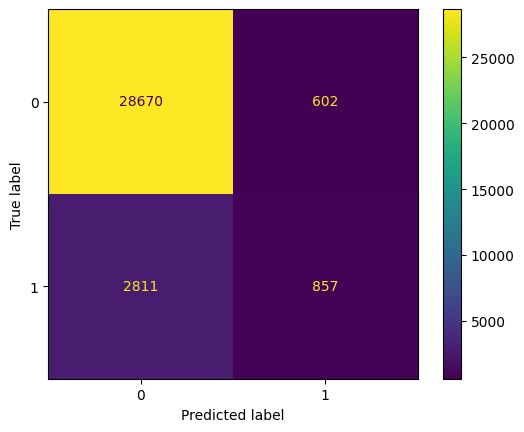

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     29272
           1       0.59      0.23      0.33      3668

    accuracy                           0.90     32940
   macro avg       0.75      0.61      0.64     32940
weighted avg       0.87      0.90      0.88     32940


Test Metrics:


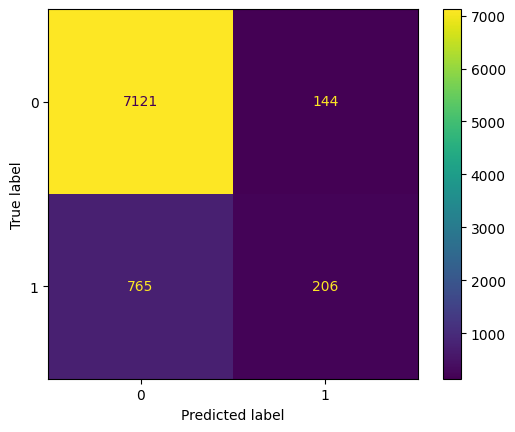

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      7265
           1       0.59      0.21      0.31       971

    accuracy                           0.89      8236
   macro avg       0.75      0.60      0.63      8236
weighted avg       0.87      0.89      0.87      8236

Logistic Regression: Best Params: {'C': 1, 'solver': 'lbfgs'}, Accuracy: 0.8896, AUC: 0.8512 , Elapsed time: 3.538001537322998


SVC with kernel (rbf)
Training Metrics:


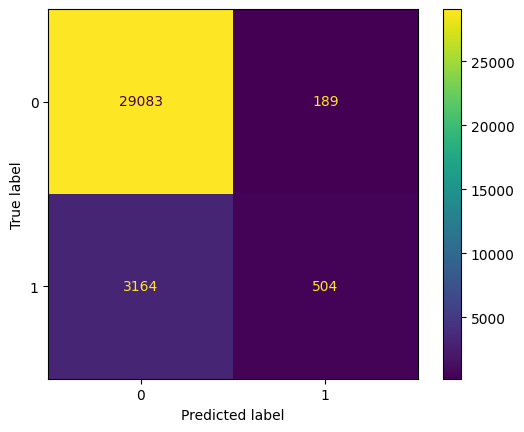

              precision    recall  f1-score   support

           0       0.90      0.99      0.95     29272
           1       0.73      0.14      0.23      3668

    accuracy                           0.90     32940
   macro avg       0.81      0.57      0.59     32940
weighted avg       0.88      0.90      0.87     32940


Test Metrics:


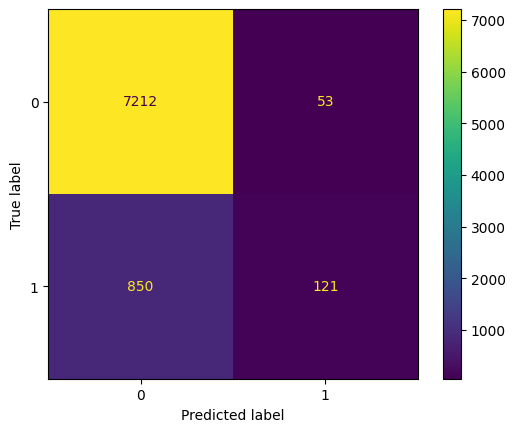

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      7265
           1       0.70      0.12      0.21       971

    accuracy                           0.89      8236
   macro avg       0.79      0.56      0.58      8236
weighted avg       0.87      0.89      0.86      8236

SVC with kernel (rbf): Best Params: {'C': 0.1, 'gamma': 1}, Accuracy: 0.8904, AUC: 0.8084 , Elapsed time: 3955.074142932892


KNN
Training Metrics:


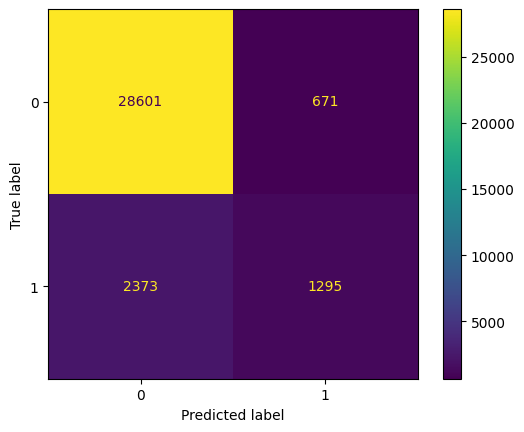

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     29272
           1       0.66      0.35      0.46      3668

    accuracy                           0.91     32940
   macro avg       0.79      0.67      0.70     32940
weighted avg       0.89      0.91      0.89     32940


Test Metrics:


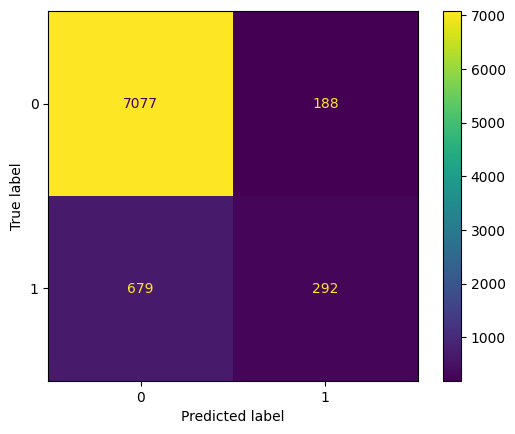

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7265
           1       0.61      0.30      0.40       971

    accuracy                           0.89      8236
   macro avg       0.76      0.64      0.67      8236
weighted avg       0.88      0.89      0.88      8236

KNN: Best Params: {'n_neighbors': 21}, Accuracy: 0.8947, AUC: 0.8734 , Elapsed time: 9.665144205093384


Decision Tree
Training Metrics:


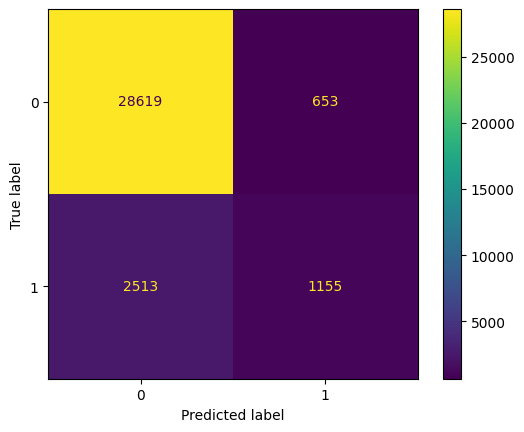

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     29272
           1       0.64      0.31      0.42      3668

    accuracy                           0.90     32940
   macro avg       0.78      0.65      0.68     32940
weighted avg       0.89      0.90      0.89     32940


Test Metrics:


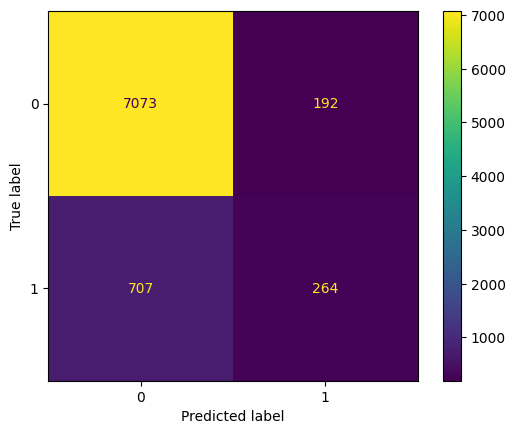

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7265
           1       0.58      0.27      0.37       971

    accuracy                           0.89      8236
   macro avg       0.74      0.62      0.66      8236
weighted avg       0.87      0.89      0.87      8236

Decision Tree: Best Params: {'max_depth': 5}, Accuracy: 0.8908, AUC: 0.8559 , Elapsed time: 2.7403721809387207


Random Forest
Training Metrics:


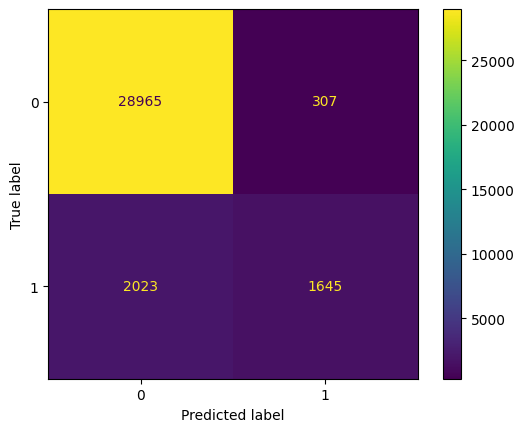

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     29272
           1       0.84      0.45      0.59      3668

    accuracy                           0.93     32940
   macro avg       0.89      0.72      0.77     32940
weighted avg       0.92      0.93      0.92     32940


Test Metrics:


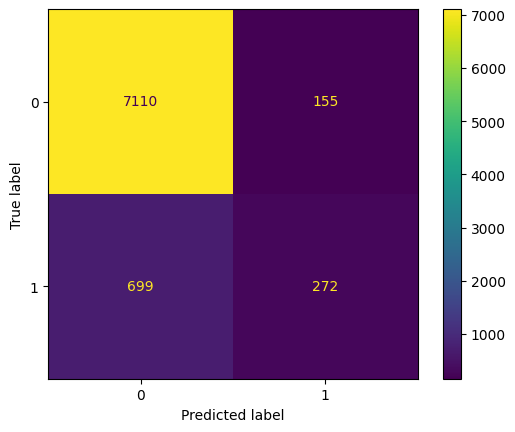

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7265
           1       0.64      0.28      0.39       971

    accuracy                           0.90      8236
   macro avg       0.77      0.63      0.67      8236
weighted avg       0.88      0.90      0.88      8236

Random Forest: Best Params: {'max_depth': 10, 'n_estimators': 300}, Accuracy: 0.8963, AUC: 0.8926 , Elapsed time: 563.2047414779663


Gradient Boosting
Training Metrics:


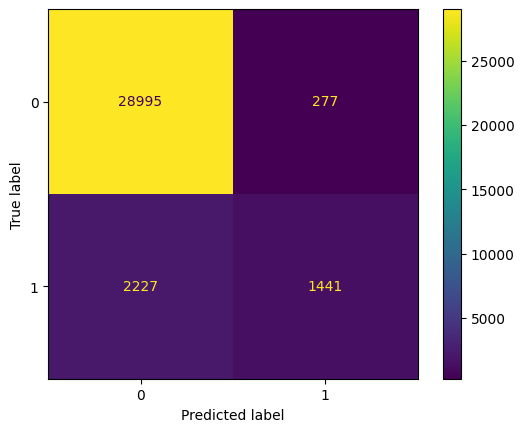

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     29272
           1       0.84      0.39      0.54      3668

    accuracy                           0.92     32940
   macro avg       0.88      0.69      0.75     32940
weighted avg       0.92      0.92      0.91     32940


Test Metrics:


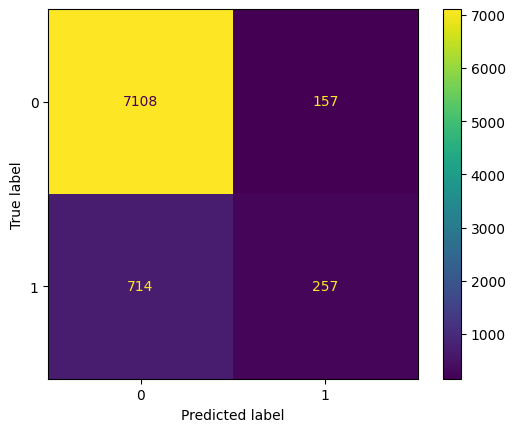

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7265
           1       0.62      0.26      0.37       971

    accuracy                           0.89      8236
   macro avg       0.76      0.62      0.66      8236
weighted avg       0.87      0.89      0.87      8236

Gradient Boosting: Best Params: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}, Accuracy: 0.8942, AUC: 0.8924 , Elapsed time: 2284.6626300811768


XGBoost
Training Metrics:


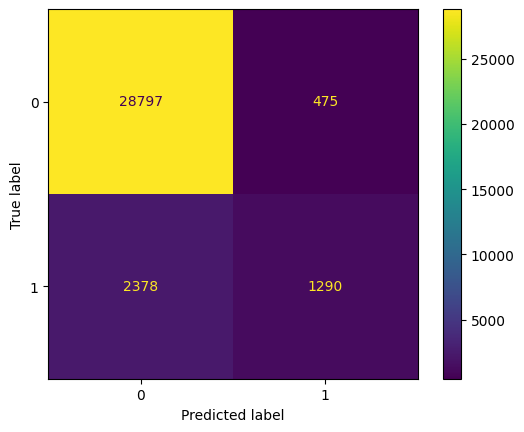

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     29272
           1       0.73      0.35      0.47      3668

    accuracy                           0.91     32940
   macro avg       0.83      0.67      0.71     32940
weighted avg       0.90      0.91      0.90     32940


Test Metrics:


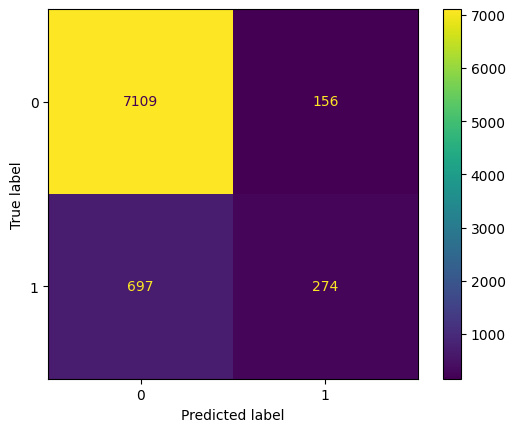

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7265
           1       0.64      0.28      0.39       971

    accuracy                           0.90      8236
   macro avg       0.77      0.63      0.67      8236
weighted avg       0.88      0.90      0.88      8236

XGBoost: Best Params: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}, Accuracy: 0.8964, AUC: 0.9008 , Elapsed time: 66.63068056106567


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3668, number of negative: 29272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 32940, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.111354 -> initscore=-2.076985
[LightGBM] [Info] Start training from score -2.076985


LightGBM
Training Metrics:


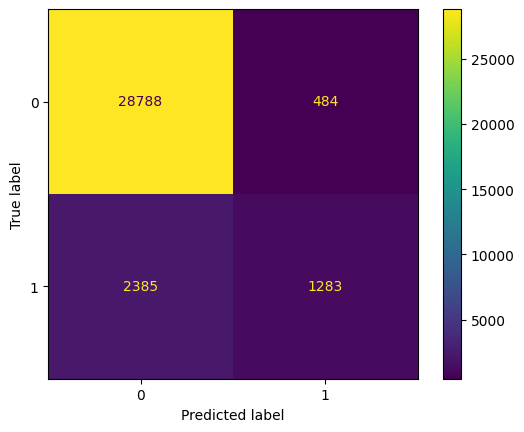

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     29272
           1       0.73      0.35      0.47      3668

    accuracy                           0.91     32940
   macro avg       0.82      0.67      0.71     32940
weighted avg       0.90      0.91      0.90     32940


Test Metrics:


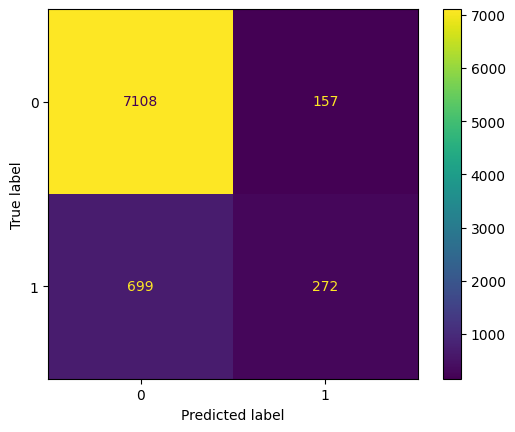

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7265
           1       0.63      0.28      0.39       971

    accuracy                           0.90      8236
   macro avg       0.77      0.63      0.67      8236
weighted avg       0.88      0.90      0.88      8236

LightGBM: Best Params: {'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 70}, Accuracy: 0.8961, AUC: 0.9050 , Elapsed time: 260.90895199775696
Best Model Overall: XGBoost with Accuracy: 0.8964, AUC: 0.9008


In [ ]:
train_and_evaluate_models_with_dataframe(df_pca, "final_ml.csv")

Uma vez que a classe y é altamente desbalanceada essa pode ser a causa para uma precision e recall tão baixa. Vamos utilizar, então undersampling para perceber se ao balancear os dados o modelo consegue prever com mais precisão quando um cliente aceita a proposta.

Dado o resultado obtido com o K-Means anteriormente, percebemos que existe uma sobreposição entre as classes maioritária (0) e minoritária (1). Assim, e após pesquisa sobre quais metodos de undersampling utilizar, optamos por usar o método de Tomek Links. Este método vai-nos permitir reduzir o tamanho da classe maioritária de forma seletiva, removendo especificamente observações ambíguas que estão próximas da classe minoritária. Como resultado, esperamos melhorar a separação entre as classes enquanto as balanceamos. Como as classes estão extremamente desbalanceadas vamos posteriormente implementar um random undersampling para ter equilibrar

In [ ]:
# Step 1: Tomek Links undersampling (clean overlapping majority class samples)
tl = TomekLinks(sampling_strategy='majority')
X_tl, y_tl = tl.fit_resample(df_pca_no_y, df_pca['y'])

# Step 2: Random undersampling (mild undersampling to further balance if needed)
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
X_final, y_final = rus.fit_resample(X_tl, y_tl)

# Combine into final balanced dataframe
df_balanced = pd.concat([pd.DataFrame(X_final, columns=df_pca_no_y.columns),
                         pd.DataFrame(y_final, columns=['y'])], axis=1)

print(df_balanced['y'].value_counts())

y
0    9278
1    4639
Name: count, dtype: int64




Logistic Regression
Training Metrics:


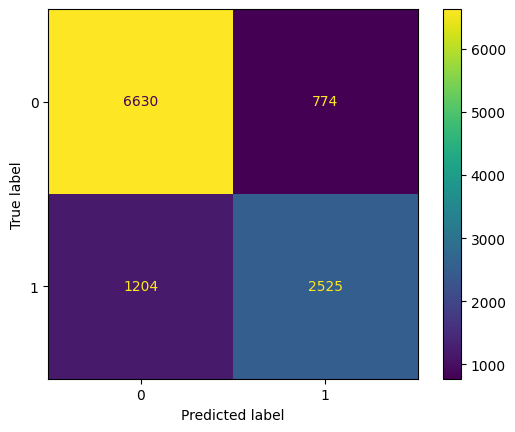

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      7404
           1       0.77      0.68      0.72      3729

    accuracy                           0.82     11133
   macro avg       0.81      0.79      0.79     11133
weighted avg       0.82      0.82      0.82     11133


Test Metrics:


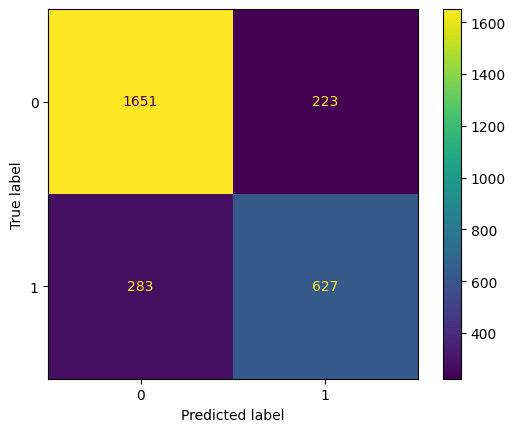

              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1874
           1       0.74      0.69      0.71       910

    accuracy                           0.82      2784
   macro avg       0.80      0.79      0.79      2784
weighted avg       0.82      0.82      0.82      2784

Logistic Regression: Best Params: {'C': 0.1, 'solver': 'lbfgs'}, Accuracy: 0.8182, AUC: 0.8601 , Elapsed time: 3.4089062213897705


SVC with kernel (rbf)
Training Metrics:


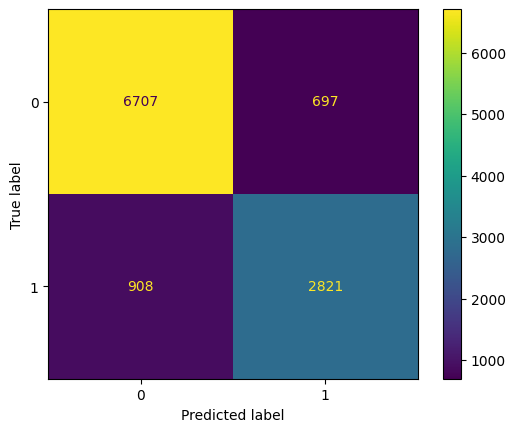

              precision    recall  f1-score   support

           0       0.88      0.91      0.89      7404
           1       0.80      0.76      0.78      3729

    accuracy                           0.86     11133
   macro avg       0.84      0.83      0.84     11133
weighted avg       0.85      0.86      0.85     11133


Test Metrics:


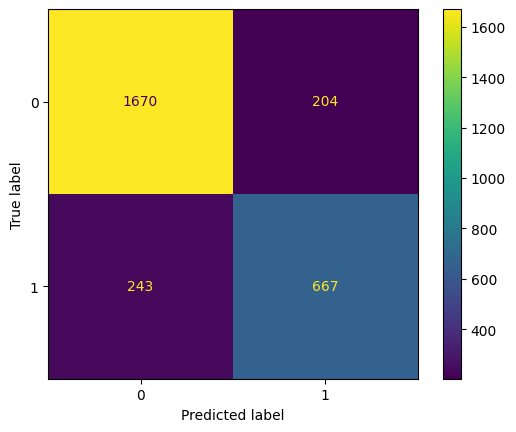

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      1874
           1       0.77      0.73      0.75       910

    accuracy                           0.84      2784
   macro avg       0.82      0.81      0.82      2784
weighted avg       0.84      0.84      0.84      2784

SVC with kernel (rbf): Best Params: {'C': 10, 'gamma': 0.1}, Accuracy: 0.8394, AUC: 0.8874 , Elapsed time: 800.6465535163879


KNN
Training Metrics:


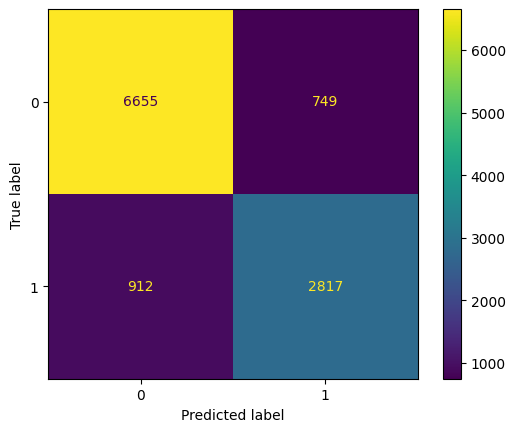

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      7404
           1       0.79      0.76      0.77      3729

    accuracy                           0.85     11133
   macro avg       0.83      0.83      0.83     11133
weighted avg       0.85      0.85      0.85     11133


Test Metrics:


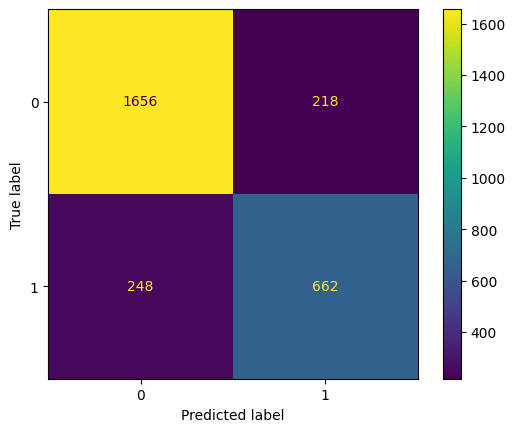

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1874
           1       0.75      0.73      0.74       910

    accuracy                           0.83      2784
   macro avg       0.81      0.81      0.81      2784
weighted avg       0.83      0.83      0.83      2784

KNN: Best Params: {'n_neighbors': 21}, Accuracy: 0.8326, AUC: 0.8884 , Elapsed time: 2.8565616607666016


Decision Tree
Training Metrics:


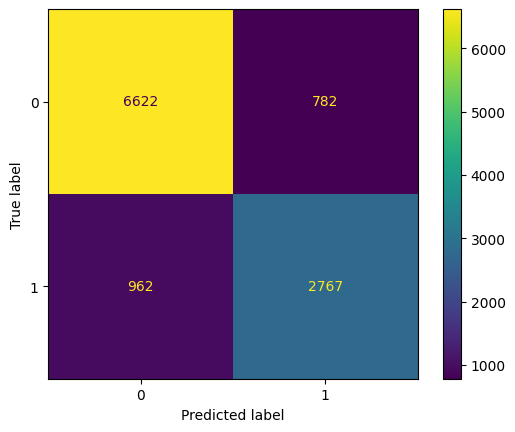

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      7404
           1       0.78      0.74      0.76      3729

    accuracy                           0.84     11133
   macro avg       0.83      0.82      0.82     11133
weighted avg       0.84      0.84      0.84     11133


Test Metrics:


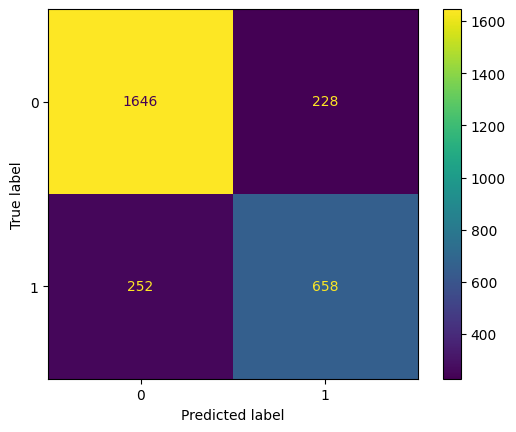

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1874
           1       0.74      0.72      0.73       910

    accuracy                           0.83      2784
   macro avg       0.80      0.80      0.80      2784
weighted avg       0.83      0.83      0.83      2784

Decision Tree: Best Params: {'max_depth': 5}, Accuracy: 0.8276, AUC: 0.8867 , Elapsed time: 1.3362987041473389


Random Forest
Training Metrics:


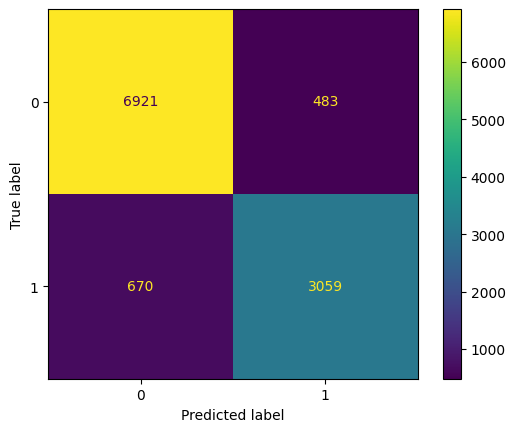

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      7404
           1       0.86      0.82      0.84      3729

    accuracy                           0.90     11133
   macro avg       0.89      0.88      0.88     11133
weighted avg       0.90      0.90      0.90     11133


Test Metrics:


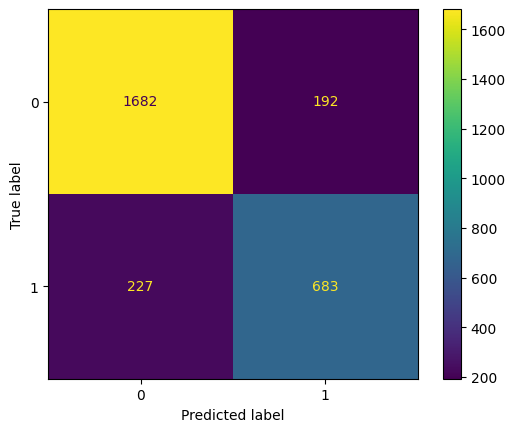

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1874
           1       0.78      0.75      0.77       910

    accuracy                           0.85      2784
   macro avg       0.83      0.82      0.83      2784
weighted avg       0.85      0.85      0.85      2784

Random Forest: Best Params: {'max_depth': 10, 'n_estimators': 200}, Accuracy: 0.8495, AUC: 0.9176 , Elapsed time: 234.4866361618042


Gradient Boosting
Training Metrics:


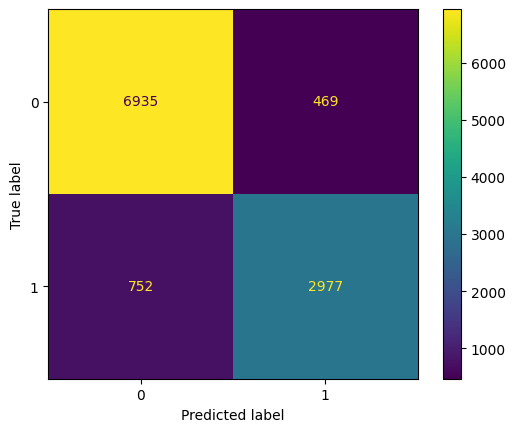

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7404
           1       0.86      0.80      0.83      3729

    accuracy                           0.89     11133
   macro avg       0.88      0.87      0.87     11133
weighted avg       0.89      0.89      0.89     11133


Test Metrics:


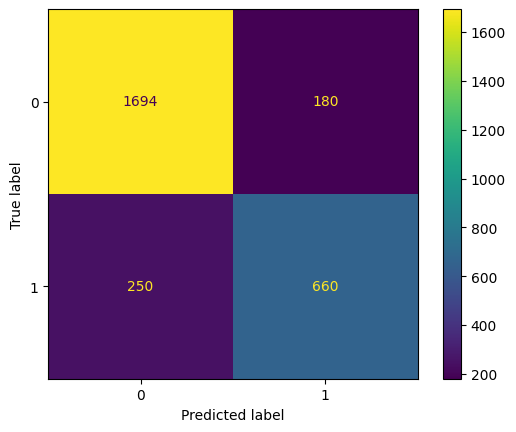

              precision    recall  f1-score   support

           0       0.87      0.90      0.89      1874
           1       0.79      0.73      0.75       910

    accuracy                           0.85      2784
   macro avg       0.83      0.81      0.82      2784
weighted avg       0.84      0.85      0.84      2784

Gradient Boosting: Best Params: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}, Accuracy: 0.8455, AUC: 0.9161 , Elapsed time: 729.5880780220032


XGBoost
Training Metrics:


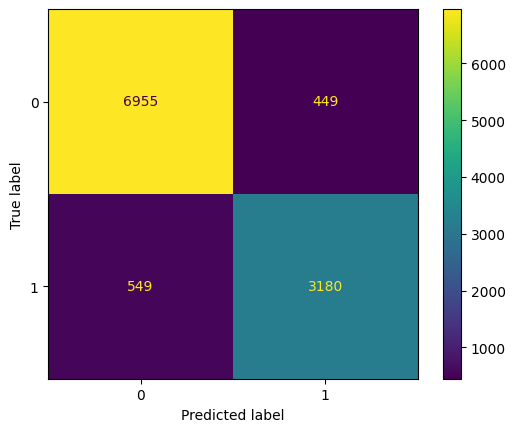

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      7404
           1       0.88      0.85      0.86      3729

    accuracy                           0.91     11133
   macro avg       0.90      0.90      0.90     11133
weighted avg       0.91      0.91      0.91     11133


Test Metrics:


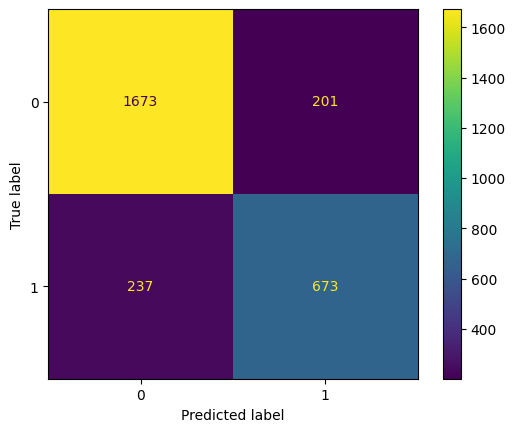

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      1874
           1       0.77      0.74      0.75       910

    accuracy                           0.84      2784
   macro avg       0.82      0.82      0.82      2784
weighted avg       0.84      0.84      0.84      2784

XGBoost: Best Params: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}, Accuracy: 0.8427, AUC: 0.9158 , Elapsed time: 36.4488639831543
[LightGBM] [Info] Number of positive: 3729, number of negative: 7404
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2043
[LightGBM] [Info] Number of data points in the train set: 11133, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.334950 -> initscore=-0.685880
[LightGBM] [Info] Start training from score -0.685880


LightGBM
Training Metrics:


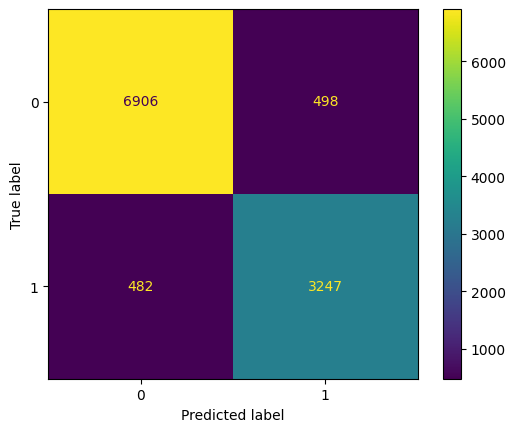

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      7404
           1       0.87      0.87      0.87      3729

    accuracy                           0.91     11133
   macro avg       0.90      0.90      0.90     11133
weighted avg       0.91      0.91      0.91     11133


Test Metrics:


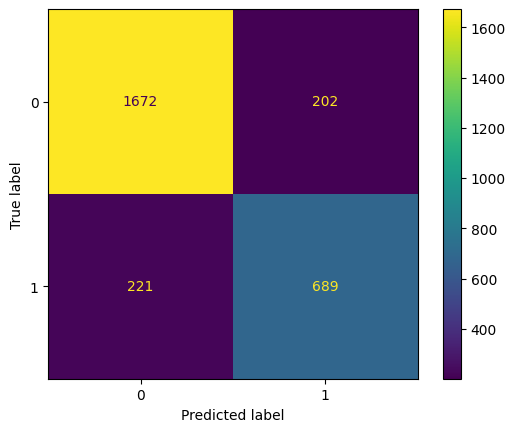

              precision    recall  f1-score   support

           0       0.88      0.89      0.89      1874
           1       0.77      0.76      0.77       910

    accuracy                           0.85      2784
   macro avg       0.83      0.82      0.83      2784
weighted avg       0.85      0.85      0.85      2784

LightGBM: Best Params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50, 'num_leaves': 70}, Accuracy: 0.8481, AUC: 0.9220 , Elapsed time: 121.33899641036987
Best Model Overall: Random Forest with Accuracy: 0.8495, AUC: 0.9176


In [ ]:
train_and_evaluate_models_with_dataframe(df_balanced, "final_balanced_ml.csv")